In [1]:
import pandas as pd
import datetime
import time
import glob
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
#import sklearn.metrics as metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pvlib
import csv

mpl.rcParams['font.size']=14
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=12
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=18
%matplotlib inline

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
## THIS IS THE CODE FOR THE TAYLOR DIAGRAM 
######
# THE ONLY THING YOU WILL NEED TO CHANGE IN THIS ARE THE UNITS FOR THE AXES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import statistics

class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.2 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.grid()
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Corr. Coeff")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')        
        # X axis
        ax.grid()
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("St Dev (W)")  #<------------- CHANGE THESE UNITS HERE
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.grid()
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("St Dev (W)") #<------------- CHANGE THESE UNITS HERE
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, '*', ls='', ms=16,c='black', label=label)
        t = np.linspace(0, (np.pi/2))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l
    def add_contours(self,levels=15,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels,colors='lightgrey')#, **kwargs)
        return contours

def srl(obsSTD, s, r, l, fname, markers, colors, handle):
    fig=plt.figure()
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = colors
    m = markers
    srlc = zip(s, r, l, cs, m)
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker=i[4], markersize=3)#, mew=0.001)
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(prop=dict(size='small'), loc=[0.7, 0.6],handles=handle)
    #fig.legend(False)
    #plt.title('Module Temperature', fontsize=8)
    plt.savefig(fname, dpi=300)
    plt.clf()
    plt.close(fig)
    

### import concatenated datasets

In [2]:
meta_mono = pd.read_csv('meta_mono.csv')

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_25864\584140319.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_mono = pd.read_csv('meta_mono.csv')


In [3]:
meta_bifi = pd.read_csv('meta_bifi.csv')

In [4]:
#calculate absolute percentage differences
meta_mono['DPmp_%'] = 100*abs((meta_mono['Modeled DC power (W)']-meta_mono['Measured DC power (W)'])/meta_mono['Measured DC power (W)'])
meta_mono['DGpoa_%'] = 100*abs((meta_mono['Modeled POA irradiance (W/m2)']-meta_mono['Measured POA irradiance (W/m2)'])/meta_mono['Measured POA irradiance (W/m2)'])
meta_mono['DTmod_°C'] = meta_mono['Modeled module temperature (°C)']-meta_mono['Measured module temperature (°C)']
meta_mono['DPmp_W'] = meta_mono['Modeled DC power (W)']-meta_mono['Measured DC power (W)']
meta_mono['DGpoa_W/m2'] = meta_mono['Modeled POA irradiance (W/m2)']-meta_mono['Measured POA irradiance (W/m2)']


meta_bifi['DPmp_%'] = 100*abs((meta_bifi['Modeled DC power (W)']-meta_bifi['Measured DC power (W)'])/meta_bifi['Measured DC power (W)'])
meta_bifi['DGpoa_%'] = 100*abs((meta_bifi['Modeled front POA irradiance (W/m2)']-meta_bifi['Measured front POA irradiance (W/m2)'])/meta_bifi['Measured front POA irradiance (W/m2)'])
#meta_bifi['DGpoa_rear_%'] = 100*abs((meta_bifi['Modeled rear POA irradiance (W/m2)']-meta_bifi['Measured rear POA irradiance (W/m2)'])/meta_bifi['Measured rear POA irradiance (W/m2)'])
meta_bifi['DTmod_°C'] = meta_bifi['Modeled module temperature (°C)']-meta_bifi['Measured module temperature (°C)']
meta_bifi['DPmp_W'] = meta_bifi['Modeled DC power (W)']-meta_bifi['Measured DC power (W)']
meta_bifi['DGpoa_W/m2'] = meta_bifi['Modeled front POA irradiance (W/m2)']-meta_bifi['Measured front POA irradiance (W/m2)']


In [5]:
# meta_bifi.drop(['Unnamed: 0','Modeled rear POA irradiance (W/m2)', 'Measured rear POA irradiance (W/m2)'], axis=1, inplace=True)
meta_bifi.rename(columns = {'Measured front POA irradiance (W/m2)':'Measured POA irradiance (W/m2)', 'Modeled front POA irradiance (W/m2)':'Modeled POA irradiance (W/m2)'}, inplace = True)

In [6]:
meta_mono.drop(['Unnamed: 0', 'Measured max DC power (W)','Measured min DC power (W)'], axis=1, inplace=True)
meta_mono.rename(columns = {'Measured front POA irradiance (W/m2)':'Measured POA irradiance (W/m2)', 'Modeled front POA irradiance (W/m2)':'Modeled POA irradiance (W/m2)'}, inplace = True)

In [7]:
#null_data = meta_mono[meta_mono.isnull().any(axis=1)]

In [8]:
#meta_mono.dropna(inplace = True)

In [9]:
#meta_bifi.dropna(inplace = True)

In [10]:
#drop rows with no submissions
meta_mono = meta_mono[meta_mono['DGpoa_%'].notna()]
#meta_bifi = meta_bifi[meta_bifi['DGpoa_%'].notna()]

In [11]:
# meta_mono_temp = meta_mono.loc[meta_mono['Scenario'] == 'S5']

In [12]:
# meta_mono = meta_mono.loc[(meta_mono['Measured module temperature (°C)'] > 0) & (meta_mono['Scenario'].isin(['S1', 'S2', 'S3']))]

In [179]:
all_sys = pd.concat([meta_mono, meta_bifi]) # meta_mono_temp

In [180]:
#all_sys = all_sys[all_sys['DGpoa_%'].notna()]

In [181]:
filters = pd.read_csv('pvpmc_comparison_filters_ldeville.csv')

In [182]:
all_sys  = all_sys.merge(filters, how = 'left', left_on = ['Year', 'Month', 'Day', 'Hour', 'Scenario'], right_on = ['Year', 'Month', 'Day', 'Hour', 'Scenario']) 

In [183]:
pd.options.display.max_columns = None
pd.reset_option('display.max_rows')

In [184]:
all_sys = all_sys.loc[(all_sys['DTU Filter 2'] ==1) & (all_sys['DTU Filter 3'] ==1) & (all_sys['DTU Filter 4'] ==1) & (all_sys['solarGIS_bsrn_pass'] ==1) & (all_sys['SNL No Snow'] ==1)]
all_sys.drop(['DTU Filter 2', 'DTU Filter 3', 'DTU Filter 4','solarGIS_bsrn_pass', 'SNL No Snow'], axis=1, inplace=True)

In [185]:
all_sys = all_sys.loc[all_sys['Modeled POA irradiance (W/m2)'] > 100]
# all_sys = all_sys.loc[all_sys['Modeled POA irradiance (W/m2)'] > 50]

In [186]:
all_sys = all_sys.loc[all_sys['Measured DC power (W)'] > 50]

In [187]:
#S4-S6 do not have temperature data so the DTmod should be NAN
all_sys['DTmod_°C'][all_sys['Scenario']== 'S4'] = np.nan
all_sys['DTmod_°C'][all_sys['Scenario']== 'S5'] = np.nan
all_sys['DTmod_°C'][all_sys['Scenario']== 'S6'] = np.nan

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_25864\2897656878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sys['DTmod_°C'][all_sys['Scenario']== 'S5'] = np.nan
C:\Users\lmdevil\AppData\Local\Temp\ipykernel_25864\2897656878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sys['DTmod_°C'][all_sys['Scenario']== 'S6'] = np.nan


In [188]:
all_sys['datetime'] = pd.to_datetime(all_sys[['Year', 'Month', 'Day', 'Hour']])

In [189]:
%matplotlib inline 
mpl.rcParams['font.size']=10
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['axes.titlesize']=10
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=0.75)

In [190]:
s1_only = all_sys.loc[all_sys['Scenario']=='S1']
s2_only = all_sys.loc[all_sys['Scenario']=='S2']
s3_only = all_sys.loc[all_sys['Scenario']=='S3']
s4_only = all_sys.loc[all_sys['Scenario']=='S4']
s5_only = all_sys.loc[all_sys['Scenario']=='S5']
s6_only = all_sys.loc[all_sys['Scenario']=='S6']

In [175]:
#MAKES LOW IRRADIANCE DATASETS
s1_only_low = s1_only.loc[s1_only['Modeled POA irradiance (W/m2)'] < 400]
s1_only_low = s1_only_low.loc[s1_only_low['Modeled POA irradiance (W/m2)'] > 50]
s2_only_low = s2_only.loc[s2_only['Modeled POA irradiance (W/m2)'] < 400]
s2_only_low = s2_only_low.loc[s2_only_low['Modeled POA irradiance (W/m2)'] > 50]

In [191]:
# # #S1


line_0 = Line2D([0], [0], color='black', linewidth=3, linestyle='solid',label='Observed')
line_1 = Line2D([0], [0], color='blue', linewidth=3, linestyle='solid',label='Plant Predict')
line_2 = Line2D([0], [0], color='red', linewidth=3, linestyle='solid',label='PVSyst')
line_3 = Line2D([0], [0], color='green', linewidth=3, linestyle='solid',label='SDM')
line_4 = Line2D([0], [0], color='orange', linewidth=3, linestyle='solid',label='SAM (CEC)')
line_6 = Line2D([0], [0], color='brown', linewidth=3, linestyle='solid',label='Other Software')
line_5 = Line2D([0], [0], color='purple', linewidth=3, linestyle='solid',label='Other Model')
line_7 = Line2D([0], [0], color='deeppink', linewidth=3, linestyle='solid',label='Custom Model')
lines = [line_0,line_1,line_2,line_3,line_4,line_5,line_6,line_7]

#full color for models
# colors =  [blue,brown,red,orange,red,purple,brown,red,blue,orange,orange,red,deeppink,red,purple,brown,red,deeppink,red,green,green,purple,purple,brown,green,orange,red,deeppink,]

# # # survey answer color scale
# #iec 61854 only
#colors = [green,red,red,red,red,red,red,green,red,red,red,grey,green,green,red,red,green,green,red,red,red,red,grey,grey,red,red,red,green]
# # #pan file only
#colors = [red,red,green,red,green,red,green,green,green,red,green,grey,red,green,red,red,green,red,green,green,green,red,grey,grey,red,red,green,green,red]
# ## either or
# colors=[green,red,green,red,green,red,green,green,green,red,green,grey,green,green,red,red,green,green,green,green,green,red,grey,grey,red,red,green,green]

# markers = [x,s,o,'+',o,'^',s,o,x,'+','+',o,d,o,'^',s,o,d,o,X,X,'^','^',s,X,'+',o,d]
# participants = s1_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s1_only.loc[s1_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s1_only.loc[s1_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s1_only.loc[s1_only['Participant']==participant]['Modeled DC power (W)'],
#               s1_only.loc[s1_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)

# # #S2

#full color for models
# #colors =  [blue,brown,red,orange,red,purple,brown,red,blue,orange,orange,red,deeppink,red,purple,brown,red,deeppink,red,green,green,purple,purple,brown,green,orange,red,deeppink,red]

# # # # survey answer color scale
# # #iec 61854
#colors = [green,red,green,red,red,red,red,green,red,red,red,grey,green,red,red,red,green,green,red,red,red,red,grey,grey,red,red,red,green,green]
# # #pan file
#colors = [red,red,green,red,green,red,green,green,green,red,green,grey,red,green,red,red,green,red,green,green,green,red,grey,grey,red,red,green,green,red,]
## either or
#colors=[green,red,green,red,green,red,green,green,green,red,green,grey,green,green,red,red,green,green,green,green,green,red,grey,grey,red,red,green,green,green]


# markers = [x,s,o,'+',o,'^',s,o,x,'+','+',o,d,o,'^',s,o,d,o,X,X,'^','^',s,X,'+',o,d,o]
# participants = s2_only_low['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s2_only_low.loc[s2_only_low['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s2_only_low.loc[s2_only_low['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s2_only_low.loc[s2_only_low['Participant']==participant]['Modeled DC power (W)'],
#               s2_only_low.loc[s2_only_low['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)


In [192]:
# Output file name
fname = 'TaylorDiagram_S1_yesboth_highirr.svg'
mpl.rcParams['font.size']=10
srl(observed, stdevs, corrcoefs, participants, fname, markers, colors, lines)

In [61]:
#module temperature
blue = 'blue' #Pvsyst tmod
green = 'green' #noct
red = 'red' #pvsyst tcell
purple = 'purple' #sapm
orange = 'orange' #custom
brown = 'brown' #faiman
yellow = 'yellow'  #other model
x = 'x'
o = 'o'
s = 's'
d='d'
X = 'X'
line_0 = Line2D([0], [0], color='black', linewidth=3, linestyle='solid',label='Observed')
line_1 = Line2D([0], [0], color='blue', linewidth=3, linestyle='solid',label='PVSyst (Tmod)')
line_2 = Line2D([0], [0], color='red', linewidth=3, linestyle='solid',label='PVSyst (Tcell)')
line_3 = Line2D([0], [0], color='green', linewidth=3, linestyle='solid',label='NOCT')
line_4 = Line2D([0], [0], color='purple', linewidth=3, linestyle='solid',label='SAPM')
line_6 = Line2D([0], [0], color='brown', linewidth=3, linestyle='solid',label='Faiman')
line_5 = Line2D([0], [0], color='orange', linewidth=3, linestyle='solid',label='Custom Model')
line_7 = Line2D([0], [0], color='yellow', linewidth=3, linestyle='solid',label='Other Model')
lines = [line_0,line_1,line_2,line_3,line_4,line_6,line_5,line_7]
# #S1
# colors = [blue,green,red,green,red,purple,orange,red,blue,green,green,red,brown,red,purple,purple,red,purple,red,yellow,brown,purple,purple,yellow,purple,green,red,orange]
# markers = [x,o,s,o,s,'+','^',s,x,o,o,s,d,s,'+','+',s,'+',s,X,d,'+','+',X,'+',o,d,'^']

# participants = s1_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s1_only.loc[s1_only['Participant']==1]['Measured module temperature (°C)'])
# for participant in participants:
#     stats = statistics.stdev(s1_only.loc[s1_only['Participant']==participant]['Modeled module temperature (°C)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s1_only.loc[s1_only['Participant']==participant]['Modeled module temperature (°C)'],
#               s1_only.loc[s1_only['Participant']==participant]['Measured module temperature (°C)'])[0][1]
#     corrcoefs.append(r)
    
# # #S2
# colors = [blue,green,red,green,red,purple,orange,red,blue,green,green,red,brown,red,purple,purple,red,purple,red,yellow,brown,purple,purple,yellow,purple,green,red,orange,red]
# markers = [x,o,s,o,s,'+','^',s,x,o,o,s,d,s,'+','+',s,'+',s,X,d,'+','+',X,'+',o,d,'^',d]
# participants = s2_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s2_only.loc[s2_only['Participant']==1]['Measured module temperature (°C)'])
# for participant in participants:
#     stats = statistics.stdev(s2_only.loc[s2_only['Participant']==participant]['Modeled module temperature (°C)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s2_only.loc[s2_only['Participant']==participant]['Modeled module temperature (°C)'],
#               s2_only.loc[s2_only['Participant']==participant]['Measured module temperature (°C)'])[0][1]
#     corrcoefs.append(r)
    


In [62]:
# Output file name
fname = 'TaylorDiagram_S2_participants_temp.svg'
mpl.rcParams['font.size']=10
srl(observed, stdevs, corrcoefs, participants, fname, markers, colors, lines)

In [54]:
rea_poa_s4 = s4_only[((s4_only.Month == 3))]
rea_poa_s6 = s6_only[((s6_only.Month == 3) | (s6_only.Month == 2))]
rea_poa_s6 = rea_poa_s6[~((rea_poa_s6.Month == 2) & (s6_only.Day == 1) | (rea_poa_s6.Month == 2) & (s6_only.Day == 2) |
                        (rea_poa_s6.Month == 2) & (s6_only.Day == 3) |(rea_poa_s6.Month == 2) & (s6_only.Day == 4) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 5) |(rea_poa_s6.Month == 2) & (s6_only.Day == 6) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 7) |(rea_poa_s6.Month == 2) & (s6_only.Day == 8) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 9) |(rea_poa_s6.Month == 2) & (s6_only.Day == 10) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 11) |(rea_poa_s6.Month == 2) & (s6_only.Day == 12) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 13) |(rea_poa_s6.Month == 2) & (s6_only.Day == 14) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 15) |(rea_poa_s6.Month == 2) & (s6_only.Day == 16) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 17) |(rea_poa_s6.Month == 2) & (s6_only.Day == 18) |
                          (rea_poa_s6.Month == 2) & (s6_only.Day == 19) |(rea_poa_s6.Month == 2) & (s6_only.Day == 20))]

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_17080\3954859532.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rea_poa_s6 = rea_poa_s6[~((rea_poa_s6.Month == 2) & (s6_only.Day == 1) | (rea_poa_s6.Month == 2) & (s6_only.Day == 2) |


In [103]:
#irradiance
blue = 'blue' #perez
green = 'green' #isotropic
red = 'red' #haydavies
purple = 'purple' #other model
orange = 'orange' #custom model
white='white'
x = 'x'
o = 'o'
s = 's'
d='d'

line_0 = Line2D([0], [0], color='black', linewidth=3, linestyle='solid',label='Observed')
line_1 = Line2D([0], [0], color='blue', linewidth=3, linestyle='solid',label='Perez')
line_2 = Line2D([0], [0], color='green', linewidth=3, linestyle='solid',label='Isotropic')
line_3 = Line2D([0], [0], color='red', linewidth=3, linestyle='solid',label='Haydavies')
line_4 = Line2D([0], [0], color='purple', linewidth=3, linestyle='solid',label='Other Model')
line_6 = Line2D([0], [0], color='orange', linewidth=3, linestyle='solid',label='Custom Model')
lines = [line_0,line_1,line_2,line_3,line_4,line_6]


#S2
# markers = [x,x,x,x,x,o,x,x,'+',s,x,'+',s,x,x,x,x,'+',x,x,x,s,x,'+',x,x,x,d,x]
# colors = [blue,blue,blue,blue,blue,green,blue,blue,red,purple,blue,red,green,blue,blue,blue,blue,red,blue,blue,blue,purple,blue,red,blue,blue,blue,orange,blue]

# participants = s2_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s2_only.loc[s2_only['Participant']==1]['Measured POA irradiance (W/m2)'])
# for participant in participants:
#     stats = statistics.stdev(s2_only.loc[s2_only['Participant']==participant]['Modeled POA irradiance (W/m2)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s2_only.loc[s2_only['Participant']==participant]['Modeled POA irradiance (W/m2)'],
#               s2_only.loc[s2_only['Participant']==participant]['Measured POA irradiance (W/m2)'])[0][1]
#     corrcoefs.append(r)

#S3
# markers = [x,x,x,x,x,o,x,x,'+',s,x,'+',x,x,x,x,'+',x,x,x,'+',x,x,x,x]
# colors = [blue,blue,blue,blue,blue,green,blue,blue,red,purple,blue,red,blue,blue,blue,blue,red,blue,blue,blue,red,blue,blue,blue,blue]

# participants = s3_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s3_only.loc[s3_only['Participant']==1]['Measured POA irradiance (W/m2)'])
# for participant in participants:
#     stats = statistics.stdev(s3_only.loc[s3_only['Participant']==participant]['Modeled POA irradiance (W/m2)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s3_only.loc[s3_only['Participant']==participant]['Modeled POA irradiance (W/m2)'],
#               s3_only.loc[s3_only['Participant']==participant]['Measured POA irradiance (W/m2)'])[0][1]
#     corrcoefs.append(r)

# # #S5
# markers = [x,x,x,x,x,o,x,x,'+',s,x,'+',o,x,x,x,x,'+',x,x,x,s,'+',x,x,x,d]
# colors = [blue,blue,blue,blue,blue,green,blue,blue,red,purple,blue,red,green,blue,blue,blue,blue,red,blue,blue,blue,purple,red,blue,blue,blue,orange]

# participants = s5_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s5_only.loc[s5_only['Participant']==1]['Measured POA irradiance (W/m2)'])
# for participant in participants:
#     stats = statistics.stdev(s5_only.loc[s5_only['Participant']==participant]['Modeled POA irradiance (W/m2)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s5_only.loc[s5_only['Participant']==participant]['Modeled POA irradiance (W/m2)'],
#               s5_only.loc[s5_only['Participant']==participant]['Measured POA irradiance (W/m2)'])[0][1]
#     corrcoefs.append(r)


# # #S4
# markers = [x,x,x,x,x,None,None,x,'+',s,x,'+',None,x,x,x,x,'+',x,x,x,None,None,'+',x,x,x,None,x]
# colors = [blue,blue,blue,blue,blue,white,white,blue,red,purple,blue,red,white,blue,blue,blue,blue,red,blue,blue,blue,white,white,red,blue,blue,blue,white,blue]

# participants = rea_poa_s4['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(rea_poa_s4.loc[rea_poa_s4['Participant']==1]['Measured rear POA irradiance (W/m2)'])
# for participant in participants:
#     stats = statistics.stdev(rea_poa_s4.loc[rea_poa_s4['Participant']==participant]['Modeled rear POA irradiance (W/m2)'])
#     stdevs.append(stats)
#     r = np.corrcoef(rea_poa_s4.loc[rea_poa_s4['Participant']==participant]['Modeled rear POA irradiance (W/m2)'],
#               rea_poa_s4.loc[rea_poa_s4['Participant']==participant]['Measured rear POA irradiance (W/m2)'])[0][1]
#     corrcoefs.append(r)


#S6
# markers = [x,x,x,x,x,None,None,x,'+',s,x,'+',None,x,x,x,x,'+',x,x,x,s,None,'+',x,x,x,None,None]
# colors = [blue,blue,blue,blue,blue,white,white,blue,red,purple,blue,red,white,blue,blue,blue,blue,red,blue,blue,blue,purple,white,red,blue,blue,blue,white,white]

# participants = rea_poa_s6['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(rea_poa_s6.loc[rea_poa_s6['Participant']==1]['Measured rear POA irradiance (W/m2)'])
# for participant in participants:
#     stats = statistics.stdev(rea_poa_s6.loc[rea_poa_s6['Participant']==participant]['Modeled rear POA irradiance (W/m2)'])
#     stdevs.append(stats)
#     r = np.corrcoef(rea_poa_s6.loc[rea_poa_s6['Participant']==participant]['Modeled rear POA irradiance (W/m2)'],
#               rea_poa_s6.loc[rea_poa_s6['Participant']==participant]['Measured rear POA irradiance (W/m2)'])[0][1]
#     corrcoefs.append(r)







In [104]:
# Output file name
fname = 'TaylorDiagram_S2_participants_poa.svg'
mpl.rcParams['font.size']=10
srl(observed, stdevs, corrcoefs, participants, fname, markers, colors, lines)

In [ ]:
red,red,green,red,green,red,green,green,green,red,green,grey,red,green,red,red,green,red,green,green,green,red,grey,grey,red,red,green,green,red,


In [193]:
# Output file name
fname = 'TaylorDiagram_S1_lowlight_all.svg'
mpl.rcParams['font.size']=10
srl(observed, stdevs, corrcoefs, participants, fname, markers, colors, lines)

In [93]:
###RUN THIS CELL TO MAKE THE DATA FOR A TAYLOR DIAGRAM FOR DC POWER FOR ANY OF THE SCENARIOS
## UNCOMMENT WHICHEVER SCENARIO IS DESIRED
## LEAVE THE TOP UNCOMMENTED, IT IS FOR THE LEGEND WHICH IS THE SAME FOR ALL 
## TAYLOR DIAGRAM IS MADE IN NEXT CELL

#dc power
blue = 'blue' #plant predict
green = 'green' #SDM
red = 'red' #pvsyst
purple = 'purple' #other model
orange = 'orange' #SAM cec
brown = 'brown' #other software
deeppink = 'deeppink' #custom model
white = 'white' #Nans
grey = 'grey'

x = 'x'
o = 'o'
s = 's'
d='d'
X ='X'

line_0 = Line2D([0], [0], color='black', linewidth=3, linestyle='solid',label='Observed')
line_1 = Line2D([0], [0], color='blue', linewidth=3, linestyle='solid',label='Plant Predict')
line_2 = Line2D([0], [0], color='red', linewidth=3, linestyle='solid',label='PVSyst')
line_3 = Line2D([0], [0], color='green', linewidth=3, linestyle='solid',label='SDM')
line_4 = Line2D([0], [0], color='orange', linewidth=3, linestyle='solid',label='SAM (CEC)')
line_6 = Line2D([0], [0], color='brown', linewidth=3, linestyle='solid',label='Other Software')
line_5 = Line2D([0], [0], color='purple', linewidth=3, linestyle='solid',label='Other Model')
line_7 = Line2D([0], [0], color='deeppink', linewidth=3, linestyle='solid',label='Custom Model')
lines = [line_0,line_1,line_2,line_3,line_4,line_5,line_6,line_7]

# x = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
#                           markersize=10, label='Plant Predict')
# square = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
#                           markersize=10, label='Other Software')
# triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
#                           markersize=10, label='Other Model')
# circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
#                           markersize=10, label='PVSyst')
# diamond = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
#                           markersize=10, label='Custom Model')
# plus = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
#                           markersize=10, label='SAM (CEC)')
# thickx = mlines.Line2D([], [], color='black', marker='X', linestyle='None',
#                           markersize=10, label='SDM')
# lines=[x,circle,thickx,plus,triangle,square,diamond]


# # #S1
# colors =  [blue,brown,red,orange,red,purple,brown,red,blue,orange,orange,red,deeppink,red,purple,brown,red,deeppink,red,green,green,purple,purple,brown,green,orange,red,deeppink,]
# markers = [x,s,o,'+',o,'^',s,o,x,'+','+',o,d,o,'^',s,o,d,o,X,X,'^','^',s,X,'+',o,d]
# participants = s1_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s1_only.loc[s1_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s1_only.loc[s1_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s1_only.loc[s1_only['Participant']==participant]['Modeled DC power (W)'],
#               s1_only.loc[s1_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)

# # #S2
# colors =  [blue,brown,red,orange,red,purple,brown,red,blue,orange,orange,red,deeppink,red,purple,brown,red,deeppink,red,green,green,purple,purple,brown,green,orange,red,deeppink,red]
# markers = [x,s,o,'+',o,'^',s,o,x,'+','+',o,d,o,'^',s,o,d,o,X,X,'^','^',s,X,'+',o,d,o]
# participants = s2_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s2_only.loc[s2_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s2_only.loc[s2_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s2_only.loc[s2_only['Participant']==participant]['Modeled DC power (W)'],
#               s2_only.loc[s2_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)

# #S3
# colors =  [blue,brown,red,orange,red,purple,brown,red,blue,orange,orange,red,red,purple,brown,red,deeppink,red,green,green,brown,green,orange,red,red]
# markers = [x,s,o,'+',o,'^',s,o,x,'+','+',o,o,'^',s,o,d,o,X,X,s,X,'+',o,o]
# participants = s3_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s3_only.loc[s3_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s3_only.loc[s3_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s3_only.loc[s3_only['Participant']==participant]['Modeled DC power (W)'],
#               s3_only.loc[s3_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)

# #S4
# colors =  [blue,brown,red,orange,red,white,white,red,blue,orange,orange,red,white,red,purple,brown,red,deeppink,red,green,green,white,white,brown,green,orange,red,white,red]
# markers = [X,s,o,'+',o,None,None,o,x,'+','+',o,None,o,'^',s,o,d,o,X,X,None,None,s,X,'+',o,None,o]
# participants = s4_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s4_only.loc[s4_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s4_only.loc[s4_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s4_only.loc[s4_only['Participant']==participant]['Modeled DC power (W)'],
#               s4_only.loc[s4_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)


# #S5
# colors =  [blue,brown,red,orange,red,purple,brown,red,blue,orange,orange,red,deeppink,red,purple,brown,red,deeppink,red,green,green,purple,brown,green,orange,red,deeppink]
# markers = [x,s,o,'+',o,'^',s,o,x,'+','+',o,d,o,'^',s,o,d,o,X,X,'^',s,X,'+',o,d]
# participants = s5_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s5_only.loc[s5_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s5_only.loc[s5_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s5_only.loc[s5_only['Participant']==participant]['Modeled DC power (W)'],
#               s5_only.loc[s5_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)

# #S6
# colors =  [blue,brown,red,orange,red,white,white,red,blue,orange,orange,red,white,red,purple,brown,red,deeppink,red,green,green,purple,white,brown,green,orange,red,white,white]
# markers = [x,s,o,'+',o,None,None,o,x,'+','+',o,None,o,'^',s,o,d,o,X,X,'^',None,s,X,'+',o,None,None]
# participants = s6_only['Participant'].unique()
# stdevs = []
# corrcoefs = []
# observed = statistics.stdev(s6_only.loc[s6_only['Participant']==1]['Measured DC power (W)'])
# for participant in participants:
#     stats = statistics.stdev(s6_only.loc[s6_only['Participant']==participant]['Modeled DC power (W)'])
#     stdevs.append(stats)
#     r = np.corrcoef(s6_only.loc[s6_only['Participant']==participant]['Modeled DC power (W)'],
#               s6_only.loc[s6_only['Participant']==participant]['Measured DC power (W)'])[0][1]
#     corrcoefs.append(r)


In [143]:
# THIS CELL GENERATES TAYLOR DIAGRAM, CHANGE NAME AS NEEDED
# IT WONT DISPLAY THE DIAGRAM ONLY SAVE IT
fname = 'TaylorDiagram_test.svg'
mpl.rcParams['font.size']=10
srl(observed, stdevs, corrcoefs, participants, fname, markers, colors, lines)

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import statistics

class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.2 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.grid()
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Corr. Coeff")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')        
        # X axis
        ax.grid()
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("St Dev (W)")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.grid()
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("St Dev (W)")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, '*', ls='', ms=16,c='black', label=label)
        t = np.linspace(0, (np.pi/2))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l
    def add_contours(self,levels=15,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels,colors='lightgrey')#, **kwargs)
        return contours

def srl(obsSTD, s, r, l, fname, markers, colors, handle):
    fig=plt.figure()
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = colors
    m = markers
    srlc = zip(s, r, l, cs, m)
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker=i[4], markersize=3)#, mew=0.001)
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(prop=dict(size='small'), loc=[0.7, 0.6],handles=handle)
    #fig.legend(False)
    #plt.title('Module Temperature', fontsize=8)
    plt.savefig(fname, dpi=300)
    plt.clf()
    plt.close(fig)
    

In [129]:
srl(observed, stdevs, corrcoefs, participants, fname)

In [101]:
for i in srlc:
    print(i[2])

In [95]:
rs, ts = np.meshgrid(np.linspace(200,600 ), np.linspace(0, (np.pi / 2.0)))

In [97]:
ts

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03205707, 0.03205707, 0.03205707, ..., 0.03205707, 0.03205707,
        0.03205707],
       [0.06411414, 0.06411414, 0.06411414, ..., 0.06411414, 0.06411414,
        0.06411414],
       ...,
       [1.50668219, 1.50668219, 1.50668219, ..., 1.50668219, 1.50668219,
        1.50668219],
       [1.53873926, 1.53873926, 1.53873926, ..., 1.53873926, 1.53873926,
        1.53873926],
       [1.57079633, 1.57079633, 1.57079633, ..., 1.57079633, 1.57079633,
        1.57079633]])

In [20]:
all_sys.loc[(all_sys['Participant']==6)&(all_sys['Scenario']=='S1')].dropna()

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Participant,Measured POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),DPmp_%,DGpoa_%,DTmod_°C,DPmp_W,DGpoa_W/m2,datetime
95497,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,...,6,441.739142,5.177106,1481.974075,4.209116,2.410609,1.884396,62.378012,-10.648604,2020-01-01 09:00:00
95498,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,...,6,700.841725,15.212283,2690.471151,8.829943,1.812126,-0.201327,-237.567076,-12.700133,2020-01-01 10:00:00
95499,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.0895,2.962067,...,6,879.048814,21.670719,3308.159506,7.888003,1.527415,-1.134365,-260.947718,-13.426726,2020-01-01 11:00:00
95500,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,...,6,977.742232,30.524462,3591.209115,7.095017,1.587333,-4.689904,-254.796915,-15.520026,2020-01-01 12:00:00
95501,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,...,6,922.815757,33.635832,3374.982008,8.230547,3.334559,-7.963230,-277.779472,-30.771834,2020-01-01 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100192,2020.0,12.0,30.0,12.0,558.313265,1006.083286,50.773038,3.549533,36.6965,2.999150,...,6,978.755106,25.581024,3622.087738,7.241816,1.084290,-0.045607,-262.304937,-10.612544,2020-12-30 12:00:00
100193,2020.0,12.0,30.0,13.0,568.788879,1010.836444,49.251366,4.838967,32.166167,3.782300,...,6,994.194934,26.154208,3678.254686,7.544183,1.343525,-0.306132,-277.494253,-13.357259,2020-12-30 13:00:00
100194,2020.0,12.0,30.0,14.0,514.674771,990.969121,47.430014,5.659667,29.7255,3.773100,...,6,921.309371,24.754799,3451.133193,8.648573,1.493227,0.358196,-298.473765,-13.757236,2020-12-30 14:00:00
100195,2020.0,12.0,30.0,15.0,399.699293,934.598369,43.705132,6.128167,28.619667,3.140033,...,6,762.840375,22.591750,2909.206389,10.174628,1.811316,0.370044,-296.000920,-13.817452,2020-12-30 15:00:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


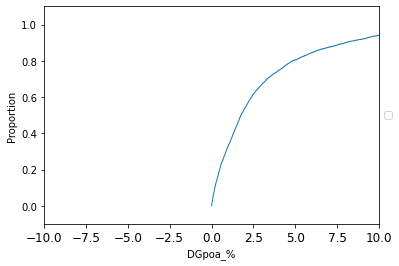

In [21]:
sns.ecdfplot(data=all_sys.loc[(all_sys['Participant']==6)&(all_sys['Scenario']=='S1')].dropna(), x='DGpoa_%', palette='bright')
plt.xlim(-10,10)
plt.ylim(-0.1,1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))#, labels=['Isotropic', 'Perez', 'Haydavies', 'Klucher', 'Reindl', 'King'] )

# Diurnal plots

In [22]:
diurnal_abq = all_sys.loc[((all_sys['Year']==2020) & (all_sys['Month']==4) & (all_sys['Day']==14) & (all_sys['Scenario'] == 'S1'))] #| ((all_sys['Year']==2020) & (all_sys['Month']==3) & (all_sys['Day']==25) & (all_sys['Scenario'].isin(['S3', 'S5'])))]
diurnal_den = all_sys.loc[ ((all_sys['Year']==2020) & (all_sys['Month']==3) & (all_sys['Day']==25) & (all_sys['Scenario'].isin(['S3', 'S5'])))]
diurnal = pd.concat([diurnal_abq, diurnal_den]) # meta_mono_temp

In [23]:
diurnal.loc[(diurnal['Modeled POA irradiance (W/m2)']> 1000) & (diurnal['datetime'] == '2020-03-25 13:00:00')]

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Participant,Measured POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),DPmp_%,DGpoa_%,DTmod_°C,DPmp_W,DGpoa_W/m2,datetime
514801,2020.0,3.0,25.0,13.0,625.530389,899.15219,78.774051,9.599167,31.143889,3.064722,...,29,625.833331,22.675,16278.53324,215.648832,70.556592,13.302,35104.46676,441.566669,2020-03-25 13:00:00


In [24]:
diurnal.loc[(diurnal['Modeled POA irradiance (W/m2)']< 750) & (diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'].isin(['S5']))]

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Participant,Measured POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),DPmp_%,DGpoa_%,DTmod_°C,DPmp_W,DGpoa_W/m2,datetime
452951,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,3.260833,...,25,923.43333,0.0,23328.406556,28.737075,33.23431,NaN,-6703.901672,-306.896691,2020-03-25 12:00:00


In [25]:
#find min and max for all 3 scenarios at 12 pm
min1 = (diurnal.loc[(diurnal['datetime'] == '2020-04-14 12:00:00') & (diurnal['Scenario'] == 'S1')]['Modeled POA irradiance (W/m2)'].min())
max1 = (diurnal.loc[(diurnal['datetime'] == '2020-04-14 12:00:00') & (diurnal['Scenario'] == 'S1')]['Modeled POA irradiance (W/m2)'].max())
meas1 = (diurnal.loc[(diurnal['datetime'] == '2020-04-14 12:00:00') & (diurnal['Scenario'] == 'S1')]['Measured POA irradiance (W/m2)'].max())
print('Upper difference for S1: ', 100*(meas1-max1)/meas1)
print('Lower difference for S1: ', 100*(meas1-min1)/meas1)
print('min', min1)
print('max', max1)
print('meas', meas1)
#print('aaa', 100*(meas1-max1)/meas1)

min3 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S3')]['Modeled POA irradiance (W/m2)'].min())
max3 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S3')]['Modeled POA irradiance (W/m2)'].max())
meas3 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S3')]['Measured POA irradiance (W/m2)'].max())
print('Upper difference for S3: ', 100*(meas3-max3)/meas3)
print('Lower difference for S3: ', 100*(meas3-min3)/meas3)
print('min', min3)
print('max', max3)
print('meas', meas3)

min5 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S5')]['Modeled POA irradiance (W/m2)'].min())
max5 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S5')]['Modeled POA irradiance (W/m2)'].max())
meas5 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S5')]['Measured POA irradiance (W/m2)'].max())
print('Upper difference for S5: ', 100*(meas5-max5)/meas5)
print('Lower difference for S5: ', 100*(meas5-min5)/meas5)
print('min', min5)
print('max', max5)
print('meas', meas5)


Upper difference for S1:  -1.3610846834695
Lower difference for S1:  5.227035507804727
min 1033.365495018
max 1105.1996527777778
meas 1090.35894419352
Upper difference for S3:  -61.2521239528902
Lower difference for S3:  10.884409348273234
min 576.964038424594
max 1044.0
meas 647.433332602183
Upper difference for S5:  1.9885929034437866
Lower difference for S5:  33.234309570937405
min 616.536638200707
max 905.07
meas 923.433329661687


time:  8.155407667160034  sec


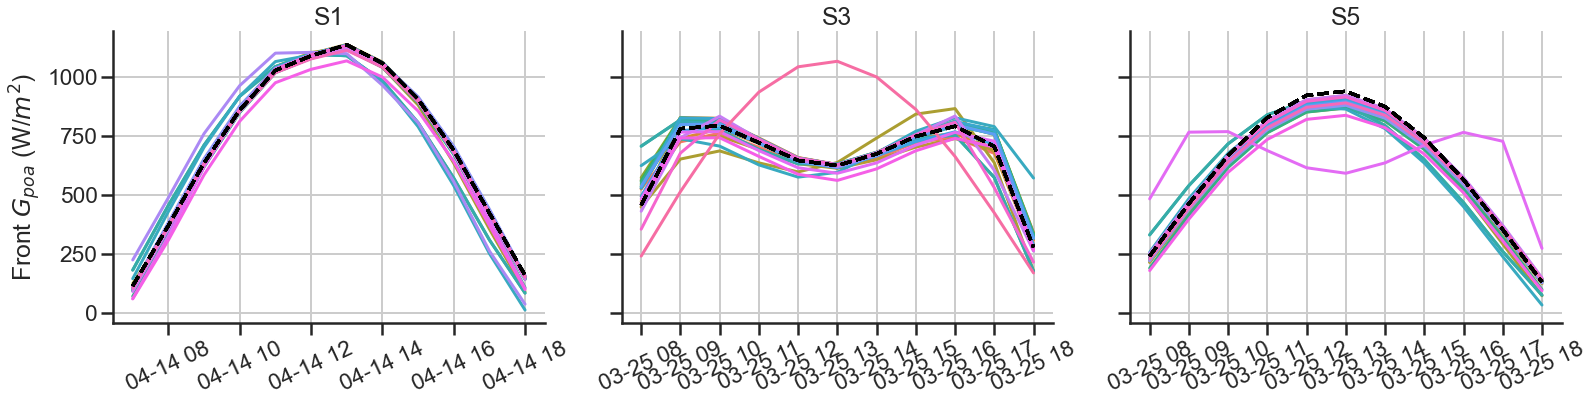

In [26]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})

g = sns.FacetGrid(diurnal, col='Scenario', hue='Participant', sharex=False, height = 6, aspect = 1.25)
g = g.map(sns.lineplot, 'datetime', 'Modeled POA irradiance (W/m2)', ci=None)#.add_legend()
g = g.map(sns.lineplot, 'datetime', 'Measured POA irradiance (W/m2)',color = 'black',linestyle = '--', ci=None)#.add_legend()
#g = sns.lineplot(data=diurnal[diurnal.Scenario.isin(['S1','S3', 'S5'])], x = 'datetime', y = 'Modeled POA irradiance (W/m2)', col="Scenario",  hue="Participant", col_wrap=3, sharex = False,  palette = "rocket_r", height = 6, aspect = 1.25)

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S1'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
# g.axes[0].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S1'])]['DGpoa_W/m2'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S3'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
# g.axes[1].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S3'])]['DGpoa_W/m2'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S5'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
# g.axes[2].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S5'])]['DGpoa_W/m2'].median()))


#g.set(xlim=(-100, 100))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Front $G_{poa}$ (W/$m^2$)')
#g.fig.supylabel("Density")
# g.fig.supxlabel("Modeled $G_{poa}$-Measured $G_{poa}$ (W/$m^2$)", fontsize = 25)
# g.set(xticks=np.arange(-100,150,50))
g.set_xticklabels( rotation=25)

g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')

# import matplotlib.pyplot as plt

# fig = plt.gcf()
# fig.set_size_inches(30, 20)

In [43]:
diurnal = pd.read_csv(r'C:\\Users\\mther\\Desktop\\PVPMC\\Blind study\\Results\\meta_bifi.csv')

In [44]:
diurnal['datetime'] = pd.to_datetime(diurnal[['Year', 'Month', 'Day', 'Hour']])

In [45]:
diurnal = diurnal.loc[ ((diurnal['Year']==2020) & (diurnal['Month']==3) & (diurnal['Day']==25) & (diurnal['Scenario'].isin(['S4', 'S6'])))]


In [46]:
diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S4')]

,Unnamed: 0,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),...,Modeled rear POA irradiance (W/m2),Modeled module temperature (°C),Modeled DC power (W),Scenario,Participant,Measured front POA irradiance (W/m2),Measured rear POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),datetime
2003,2003,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,55.619174,19.843270,16530.580292,S4,1,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
19523,19523,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,NaN,23.918300,15027.600000,S4,2,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
37043,37043,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,48.986000,28.743819,16810.000000,S4,3,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
54563,54563,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,49.385900,20.129200,15930.300000,S4,4,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
72083,72083,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,38.107000,24.494000,15830.000000,S4,5,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
89603,89603,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,NaN,NaN,NaN,S4,6,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
107123,107123,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,NaN,NaN,NaN,S4,7,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
124643,124643,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,45.244000,21.682000,16755.000000,S4,8,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
142163,142163,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,57.183296,22.817732,15869.211399,S4,9,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00
159683,159683,2020.0,3.0,25.0,12.0,613.402506,899.321888,77.081191,8.941944,32.954167,...,52.958300,21.168700,16282.050000,S4,10,647.433333,60.401083,0.0,17142.527811,2020-03-25 12:00:00


In [47]:
#find min and max for all 2 scenarios at 12 pm


min4 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S4')]['Modeled rear POA irradiance (W/m2)'].min())
max4 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S4')]['Modeled rear POA irradiance (W/m2)'].max())
meas4 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S4')]['Measured rear POA irradiance (W/m2)'].max())
print('Upper difference for S4: ', 100*(meas4-max4)/meas4)
print('Lower difference for S4: ', 100*(meas4-min4)/meas4)
print('min', min4)
print('max', max4)
print('meas', meas4)

min6 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S6')]['Modeled rear POA irradiance (W/m2)'].min())
max6 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S6')]['Modeled rear POA irradiance (W/m2)'].max())
meas6 = (diurnal.loc[(diurnal['datetime'] == '2020-03-25 12:00:00') & (diurnal['Scenario'] == 'S6')]['Measured rear POA irradiance (W/m2)'].max())
print('Upper difference for S6: ', 100*(meas6-max6)/meas6)
print('Lower difference for S6: ', 100*(meas6-min6)/meas6)
print('min', min6)
print('max', max6)
print('meas', meas6)


Upper difference for S4:  -95.35770967867431
Lower difference for S4:  99.74040200703811
min 0.1568
max 117.998172975524
meas 60.40108331
Upper difference for S6:  -149.3509880617627
Lower difference for S6:  99.5064308309694
min 0.285
max 143.981909844933
meas 57.742666658


time:  6.7430031299591064  sec


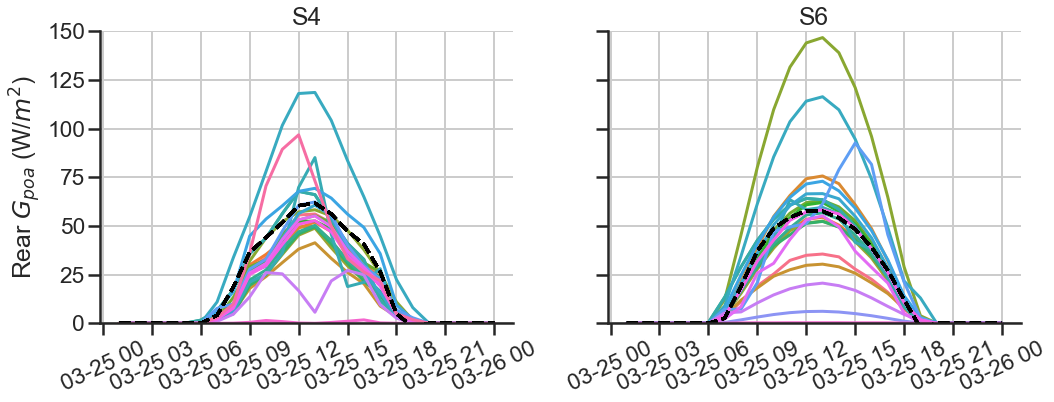

In [48]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})

g = sns.FacetGrid(diurnal, col='Scenario', hue='Participant', sharex=False, height = 6, aspect = 1.25)
g = g.map(sns.lineplot, 'datetime', 'Modeled rear POA irradiance (W/m2)', ci=None)#.add_legend()
g = g.map(sns.lineplot, 'datetime', 'Measured rear POA irradiance (W/m2)',color = 'black',linestyle = '--', ci=None)#.add_legend()
#g = sns.lineplot(data=diurnal[diurnal.Scenario.isin(['S1','S3', 'S5'])], x = 'datetime', y = 'Modeled POA irradiance (W/m2)', col="Scenario",  hue="Participant", col_wrap=3, sharex = False,  palette = "rocket_r", height = 6, aspect = 1.25)

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S1'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
# g.axes[0].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S1'])]['DGpoa_W/m2'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S3'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
# g.axes[1].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S3'])]['DGpoa_W/m2'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S5'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
# g.axes[2].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S5'])]['DGpoa_W/m2'].median()))


#g.set(xlim=(-100, 100))
g.set(ylim=(0, 150))
g.set_axis_labels('', 'Rear $G_{poa}$ (W/$m^2$)')
#g.fig.supylabel("Density")
# g.fig.supxlabel("Modeled $G_{poa}$-Measured $G_{poa}$ (W/$m^2$)", fontsize = 25)
# g.set(xticks=np.arange(-100,150,50))
g.set_xticklabels( rotation=25)

g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')

# import matplotlib.pyplot as plt

# fig = plt.gcf()
# fig.set_size_inches(30, 20)

In [49]:
# #%% Add columns: datetime, solpos, DC efficiency, Ta-Tm
# all_sys['is_abq'] = all_sys['Scenario'].isin(['S1', 'S2']) 
# all_sys['is_bifi'] = all_sys['Scenario'].isin(['S4', 'S6']) 
# all_sys['is_tracker'] = all_sys['Scenario'].isin(['S3', 'S4']) 

# all_sys['datetime'] = pd.to_datetime(all_sys[['Year', 'Month', 'Day', 'Hour']])
# #I a hard time passing a single tz aware column that containins two tzs to pvlib, so I'm breaking it into two subsets for solpos calculations 
# abq = all_sys.loc[all_sys['is_abq']] 
# cph = all_sys.loc[~all_sys['is_abq']]
# abq['local_time'] = abq['datetime'].dt.tz_localize('US/Mountain')
# cph['local_time'] = cph['datetime'].dt.tz_localize('Europe/Copenhagen')

# #NOTE: if we start analyzing data near sunrise/set then we will have to revisit how the timestamp is calculated at those times 
# solpos_abq = pvlib.solarposition.get_solarposition(time=abq['local_time']-datetime.timedelta(minutes=30), #S1-S4 hourly data are "right" ending, subtract 30 min for mid-hour
#                                                latitude=35.054, 
#                                                longitude=-106.539,
#                                                altitude=1600,
#                                                temperature=abq['Ambient Temp (°C) '])#default method (nrel_numpy): I. Reda and A. Andreas, Solar position algorithm for solar radiation applications. Solar Energy, vol. 76, no. 5, pp. 577-589, 2004

# solpos_cph = pvlib.solarposition.get_solarposition(time=cph['local_time']-datetime.timedelta(minutes=30), #S1-S4 hourly data are "right" ending, subtract 30 min for mid-hour
#                                                latitude=55.696, 
#                                                longitude= 12.104,
#                                                altitude=15,
#                                                temperature=cph['Ambient Temp (°C) '])

# abq['SolEL'] = solpos_abq.elevation.values
# abq['SolAZ'] = solpos_abq.azimuth.values
# cph['SolEL'] = solpos_cph.elevation.values
# cph['SolAZ'] = solpos_cph.azimuth.values

# #calculate idealized tracking angles. The actual recorded angles are available.
# sat_angles = pvlib.tracking.singleaxis(solpos_cph['apparent_zenith'], solpos_cph['azimuth'], axis_tilt=0, axis_azimuth=180, max_angle=60,backtrack=True,gcr=0.28)

# cph['AOI'] = np.where(cph['is_tracker'],
#                       sat_angles['aoi'].values,
#                       pvlib.irradiance.aoi(25,180,90-cph['SolEL'],cph['SolAZ']))

# abq['AOI'] = pvlib.irradiance.aoi(35,180,90-abq['SolEL'],abq['SolAZ'])

# all_sys_backup = all_sys
# all_sys = pd.concat([abq,cph])#the ['local_time'] column reverts back to object type here

# #double check that the solpos is calculated correctly, look at interesting trends by changing 'Hue'
# sub = all_sys.loc[all_sys["Participant"] == 8]

# sub['Hour'] = sub['Hour'].astype(str)
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))# sharex = 'all', sharey = 'all')
# fig.tight_layout()
# ax = sns.scatterplot(data=sub.loc[sub["Scenario"]=='S1'],x='SolAZ',y='SolEL', s=1.4, hue='Measured POA irradiance (W/m2)', ax = axes[0,0])
# ax.legend(fontsize=10)
# ax = sns.scatterplot(data=sub.loc[sub["Scenario"]=='S2'],x='SolAZ',y='SolEL', s=1.4, hue='Measured POA irradiance (W/m2)', ax = axes[0,1])
# ax.legend(fontsize=10)
# ax = sns.scatterplot(data=sub.loc[sub["Scenario"]=='S3'],x='SolAZ',y='SolEL', s=1.4, hue='Measured POA irradiance (W/m2)', ax = axes[0,2])
# ax.legend(fontsize=10)
# ax = sns.scatterplot(data=sub.loc[sub["Scenario"]=='S4'],x='SolAZ',y='SolEL', s=1.4, hue='Measured POA irradiance (W/m2)', ax = axes[1,0])
# ax.legend(fontsize=10)
# ax = sns.scatterplot(data=sub.loc[sub["Scenario"]=='S5'],x='SolAZ',y='SolEL', s=1.4, hue='Measured POA irradiance (W/m2)', ax = axes[1,1])
# ax.legend(fontsize=10)
# ax = sns.scatterplot(data=sub.loc[sub["Scenario"]=='S6'],x='SolAZ',y='SolEL', s=1.4, hue='Measured POA irradiance (W/m2)', ax = axes[1,2])
# ax.legend(fontsize=10)


# Energy yield and irradiation

In [50]:
energy_yield = all_sys.groupby(['Participant', 'Scenario'])['Modeled DC power (W)', 'Measured DC power (W)'].apply(lambda x : x.astype(float).sum())
irradiation = all_sys.groupby(['Participant', 'Scenario'])['Modeled POA irradiance (W/m2)', 'Measured POA irradiance (W/m2)'].apply(lambda x : x.astype(float).sum())

C:\Users\mther\AppData\Local\Temp/ipykernel_13792/1962494268.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  energy_yield = all_sys.groupby(['Participant', 'Scenario'])['Modeled DC power (W)', 'Measured DC power (W)'].apply(lambda x : x.astype(float).sum())
C:\Users\mther\AppData\Local\Temp/ipykernel_13792/1962494268.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  irradiation = all_sys.groupby(['Participant', 'Scenario'])['Modeled POA irradiance (W/m2)', 'Measured POA irradiance (W/m2)'].apply(lambda x : x.astype(float).sum())


In [51]:
energy_yield

Modeled DC power (W)  Measured DC power (W)
Participant Scenario                                             
1           S1                7.747164e+06           7.783493e+06
            S2                6.578778e+06           6.464690e+06
            S3                2.568659e+07           2.552787e+07
            S4                2.610567e+07           2.659845e+07
            S5                2.775672e+07           2.770803e+07
...                                    ...                    ...
28          S2                6.349396e+06           6.464690e+06
            S5                2.813111e+07           2.770803e+07
29          S2                7.176835e+06           6.464690e+06
            S3                4.879797e+07           2.552787e+07
            S4                2.723543e+07           2.659845e+07

[155 rows x 2 columns]

In [52]:
energy_yield['Absolute percentage Error (%)'] = 100*abs((energy_yield['Modeled DC power (W)']-energy_yield['Measured DC power (W)'])/energy_yield['Measured DC power (W)'])
energy_yield['Percentage Error (%)'] = 100*(energy_yield['Modeled DC power (W)']-energy_yield['Measured DC power (W)'])/energy_yield['Measured DC power (W)']
irradiation['Absolute percentage Error (%)'] = 100*abs((irradiation['Modeled POA irradiance (W/m2)']-irradiation['Measured POA irradiance (W/m2)'])/irradiation['Measured POA irradiance (W/m2)'])
irradiation['Percentage Error (%)'] = 100*(irradiation['Modeled POA irradiance (W/m2)']-irradiation['Measured POA irradiance (W/m2)'])/irradiation['Measured POA irradiance (W/m2)']
irradiation

Modeled POA irradiance (W/m2)  \
Participant Scenario                                  
1           S1                         2.268008e+06   
            S2                         2.268095e+06   
            S3                         1.071351e+06   
            S4                         1.070929e+06   
            S5                         1.173377e+06   
...                                             ...   
28          S2                         2.251102e+06   
            S5                         1.157757e+06   
29          S2                         2.260956e+06   
            S3                         1.010877e+06   
            S4                         1.011256e+06   

                      Measured POA irradiance (W/m2)  \
Participant Scenario                                   
1           S1                          2.253783e+06   
            S2                          2.253874e+06   
            S3                          1.030890e+06   
            S4                          1.031578e+06   
            S5                          1.135716e+06   
...                                              ...   
28          S2                          2.253874e+06   
            S5                          1.135716e+06   
29          S2                          2.253874e+06   
            S3                          1.030890e+06   
            S4                          1.031578e+06   

                      Absolute percentage Error (%)  Percentage Error (%)  
Participant Scenario                                                       
1           S1                             0.631193              0.631193  
            S2                             0.630940              0.630940  
            S3                             3.924825              3.924825  
            S4                             3.814662              3.814662  
            S5                             3.316060              3.316060  
...                                             ...                   ...  
28          S2                             0.123004             -0.123004  
            S5                             1.940735              1.940735  
29          S2                             0.314211              0.314211  
            S3                             1.941350             -1.941350  
            S4                             1.969928             -1.969928  

[155 rows x 4 columns]

In [53]:
energy_yield.reset_index(inplace = True)
irradiation.reset_index(inplace = True)

In [54]:
energy_yield_overall = pd.DataFrame(energy_yield.groupby(['Participant'])['Absolute percentage Error (%)'].mean()) #.apply(lambda x : x.astype(float).sum())
irradiation_overall = pd.DataFrame(irradiation.groupby(['Participant'])['Absolute percentage Error (%)'].mean()) #.apply(lambda x : x.astype(float).sum())

In [55]:
energy_yield_overall.reset_index(inplace = True)
irradiation_overall.reset_index(inplace = True)

In [56]:
energy_yield_overall

,Participant,Absolute percentage Error (%)
0,1,1.440105
1,2,7.363485
2,3,0.810845
3,4,2.323828
4,5,5.884930
5,6,7.030602
6,7,6.824716
7,8,1.973344
8,9,5.513479
9,10,4.899184


In [57]:
energy_yield_overall['Absolute percentage Error (%)'].median()

4.899184010165583

In [58]:
irradiation_overall['Absolute percentage Error (%)'].median()

1.9508273154629816

Text(0.09, 0.5, 'Mean absolute percentage error (%)')

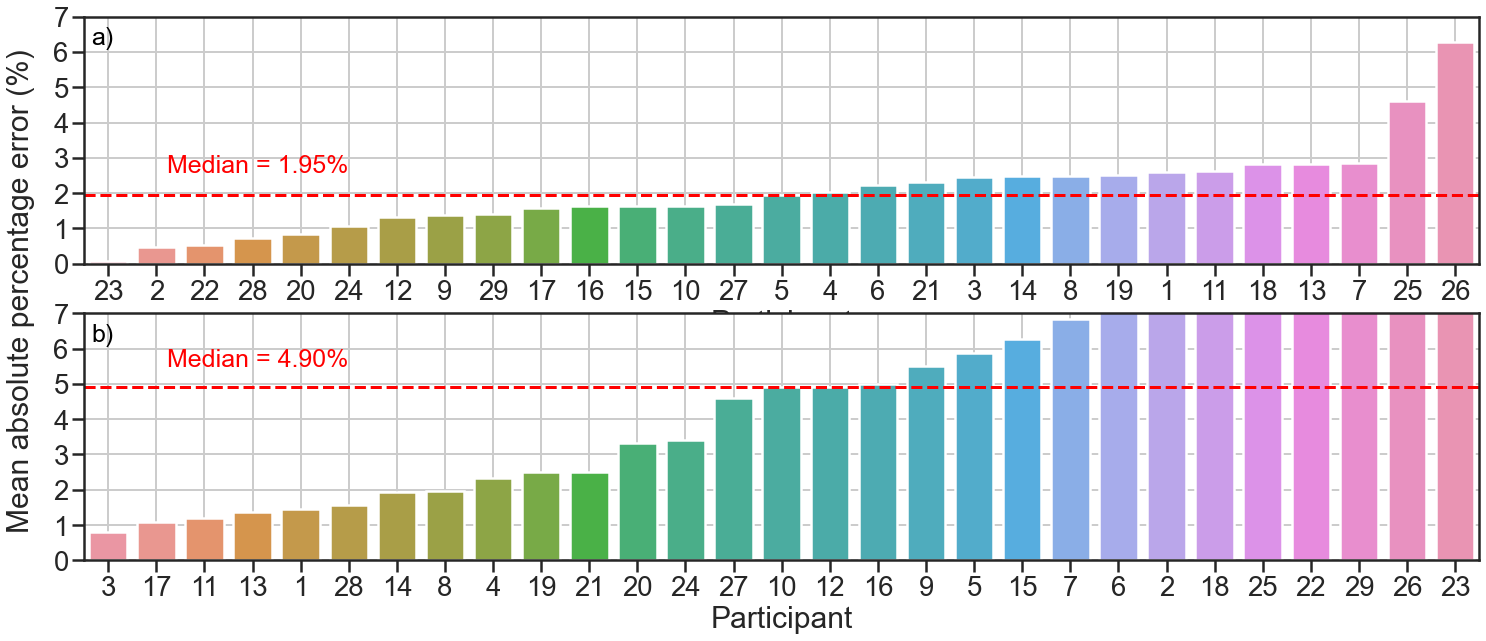

In [59]:
sns.set_context("poster", font_scale=1.25)
ylimits = [0,7]
order1 = energy_yield_overall.sort_values(by=['Absolute percentage Error (%)'])
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))
ax = sns.barplot(x="Participant", y='Absolute percentage Error (%)', data=energy_yield_overall, order = order1['Participant'],  linewidth = 2.5,  ax = axes[1])
ax.set_ylim(ylimits)
ax.grid(True)
ax.axhline(y=energy_yield_overall['Absolute percentage Error (%)'].median(), color='r', ls='--')
#ax.set_ylabel('Mean absolute percentage error (%)')
ax.annotate('Median = {}%'.format("%.2f" % energy_yield_overall['Absolute percentage Error (%)'].median()),xy=(5,5.5),ha = 'right',color = 'red',fontsize = 25)
ax.set(ylabel = None)
# tick_spacing1 = 1
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
ax.annotate('b)',xy=(0.1,6.2),ha = 'right',color = 'black',fontsize = 25)
loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)


order2 = irradiation_overall.sort_values(by=['Absolute percentage Error (%)'])
ax = sns.barplot(x="Participant", y='Absolute percentage Error (%)', data=irradiation_overall, order = order2['Participant'],  linewidth = 2.5,  ax = axes[0])
ax.set_ylim(ylimits)
ax.grid(True)
ax.axhline(y=irradiation_overall['Absolute percentage Error (%)'].median(), color='r', ls='--')
#ax.set_ylabel('Mean absolute percentage error (%)')
#ax.annotate('Median = 4.29%',xy=(5,4.4),ha = 'right',color = 'red',fontsize = 15)
ax.annotate('Median = {}%'.format("%.2f" % irradiation_overall['Absolute percentage Error (%)'].median()),xy=(5,2.6),ha = 'right',color = 'red',fontsize = 25)
ax.annotate('a)',xy=(0.1,6.2),ha = 'right',color = 'black',fontsize = 25)
loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# tick_spacing1 = 1
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
ax.set(ylabel = None)
fig.text(0.09,0.5, "Mean absolute percentage error (%)", ha="center", va="center", rotation=90)

#plt.show()
# plt.show()

In [60]:
# sns.set_context("poster", font_scale=1.25)
# ylimits = [0,7]
# order1 = irradiation_overall.sort_values(by=['Absolute percentage Error (%)'])
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))#, sharex = 'all', sharey = 'all')
# ax = sns.barplot(x="Participant", y='Absolute percentage Error (%)', data=irradiation_overall, order = order1['Participant'],  linewidth = 2.5)#,  ax = axes[0])
# ax.set_ylim(ylimits)
# ax.grid(True)
# ax.axhline(y=irradiation_overall['Absolute percentage Error (%)'].median(), color='r', ls='--')
# ax.set_ylabel('Mean absolute percentage error (%)')
# #ax.annotate('Median = 4.29%',xy=(5,4.4),ha = 'right',color = 'red',fontsize = 15)
# ax.annotate('Median = 2.41%',xy=(5,2.5),ha = 'right',color = 'red',fontsize = 15)
# # ax.annotate('S1,S2,S5',xy=(0,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(1,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(2,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(3,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(4,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(5,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(6,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(7,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(8,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(9,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(10,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(11,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(12,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(13,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(14,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('S1,S2,S3,S5',xy=(15,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(16,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('S1,S2,S3,S5',xy=(17,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(18,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('S1,S2,S5,S6',xy=(19,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All',xy=(20,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All - 28.31%',xy=(21,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All - 36.34%',xy=(22,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('S1,S2 - 68.06%',xy=(23,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All - 101.01%',xy=(24,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# # ax.annotate('All - 688.61%',xy=(25,2.2),ha = 'right',color = 'black',fontsize = 14,rotation = 90)
# #ax.annotate('37.17 kWh/m$^2$',xy=('2017-07-26',270.2),ha = 'right',color = 'black',fontsize = 11,rotation = 90)
# tick_spacing1 = 1
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
# plt.show()

In [61]:
# sns.set_context("poster", font_scale=1.25)
# ylimits = [0,14]
# order1 = aaa2.sort_values(by=['Absolute percentage Error (%)'])
# # order2 = yields.sort_values(by=['S2'])
# # order3 = yields.sort_values(by=['S3'])
# # order4 = yields.sort_values(by=['S4'])
# # order5 = yields.sort_values(by=['S5'])
# # order6 = yields.sort_values(by=['S6'])
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25
#                                                     ,10))#, sharex = 'all', sharey = 'all')
# ax = sns.boxplot(x="Participant", y='Absolute percentage Error (%)', data=aaa, showmeans = True, order = order1['Participant'],  linewidth = 2.5)#,  ax = axes[0])
# ax.set_ylim(ylimits)
# ax.grid(True)
# ax.axhline(y=aaa['Absolute percentage Error (%)'].median(), color='r', ls='--')
# ax.set_ylabel('Absolute percentage error (%)')

# plt.show()

In [62]:
#aaa2 = pd.DataFrame(aaa.groupby(['Participant'])['Percentage Error (%)'].mean()) #.apply(lambda x : x.astype(float).sum())

In [63]:
#aaa2.reset_index(inplace = True)

In [64]:
# sns.set_context("poster", font_scale=1.25)
# ylimits = [-13,7.5]
# order1 = aaa2.sort_values(by=['Percentage Error (%)'])
# # order2 = yields.sort_values(by=['S2'])
# # order3 = yields.sort_values(by=['S3'])
# # order4 = yields.sort_values(by=['S4'])
# # order5 = yields.sort_values(by=['S5'])
# # order6 = yields.sort_values(by=['S6'])
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25
#                                                     ,10))#, sharex = 'all', sharey = 'all')
# ax = sns.boxplot(x="Participant", y='Percentage Error (%)', data=aaa, showmeans = True, order = order1['Participant'],  linewidth = 2.5)#,  ax = axes[0])
# ax.set_ylim(ylimits)
# ax.grid(True)
# ax.axhline(y=aaa['Percentage Error (%)'].median(), color='r', ls='--')
# #ax.axhline(y=0, color='black', ls='--')
# ax.set_ylabel('Percentage error (%)')

# plt.show()

In [65]:
energy_yield

,Participant,Scenario,Modeled DC power (W),Measured DC power (W),Absolute percentage Error (%),Percentage Error (%)
0,1,S1,7.747164e+06,7.783493e+06,0.466737,-0.466737
1,1,S2,6.578778e+06,6.464690e+06,1.764785,1.764785
2,1,S3,2.568659e+07,2.552787e+07,0.621735,0.621735
3,1,S4,2.610567e+07,2.659845e+07,1.852659,-1.852659
4,1,S5,2.775672e+07,2.770803e+07,0.175692,0.175692
...,...,...,...,...,...,...
150,28,S2,6.349396e+06,6.464690e+06,1.783449,-1.783449
151,28,S5,2.813111e+07,2.770803e+07,1.526893,1.526893
152,29,S2,7.176835e+06,6.464690e+06,11.015917,11.015917
153,29,S3,4.879797e+07,2.552787e+07,91.155649,91.155649


In [66]:
energy_yield['Percentage Error (%)'].median()

-2.79634091584729

In [67]:
mono_fixed = energy_yield.loc[energy_yield['Scenario'].isin([ 'S1' , 'S2', 'S5'])]
mono_tracked = energy_yield.loc[energy_yield['Scenario'].isin([ 'S3'])]
bi_tracked = energy_yield.loc[energy_yield['Scenario'].isin([ 'S4'])]
bi_fixed = energy_yield.loc[energy_yield['Scenario'].isin([ 'S6'])]

-1.5510092176740886
-1.3703913928406712
-3.8793586043963795
-3.7590191213831643


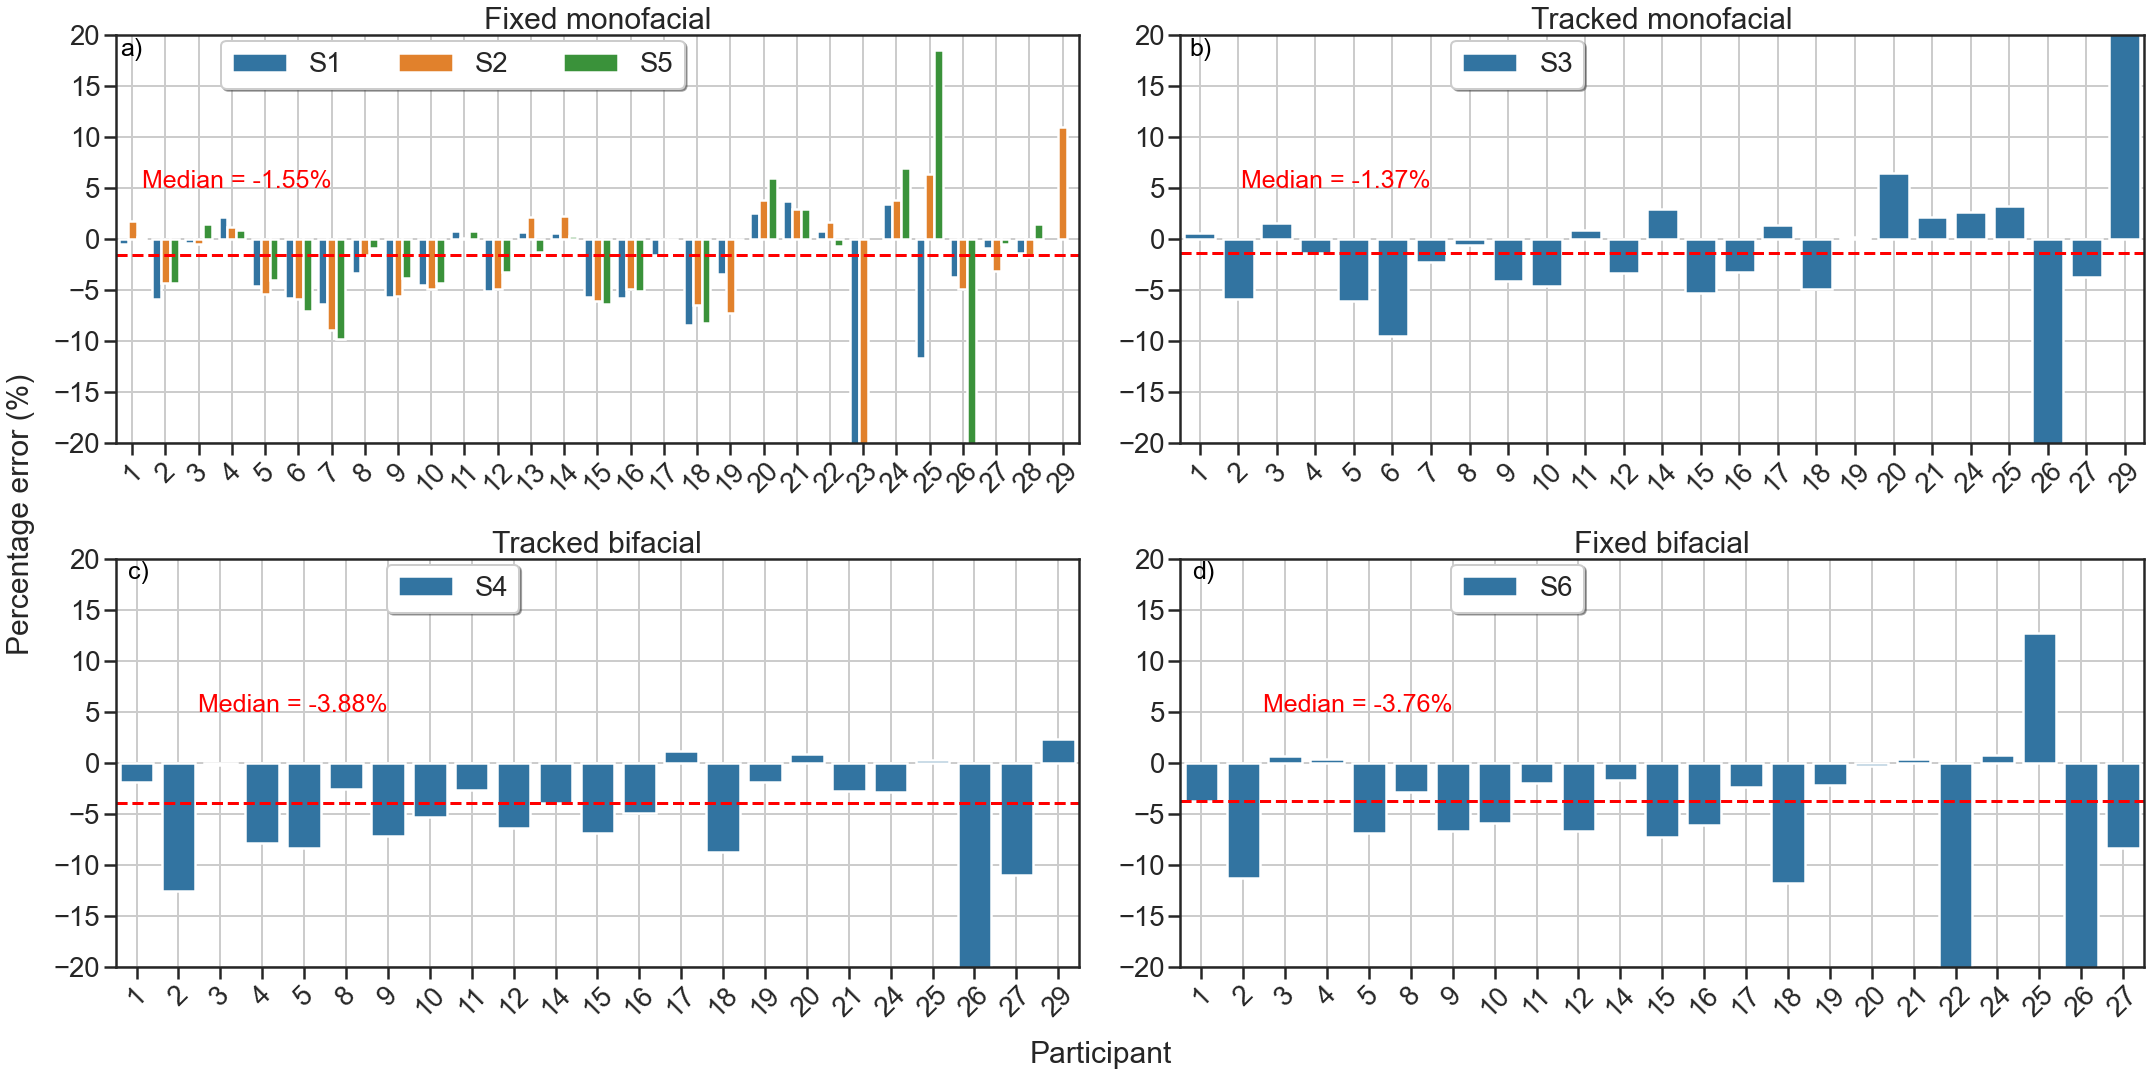

In [68]:
sns.set_context("poster", font_scale=1.25)
ylimits = [-20,20]
#order1 = aaa.sort_values(by=['Percentage Error (%)'])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,15))#, sharex = 'all', sharey = 'all')
ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=mono_fixed,  linewidth = 2.5, ax = axes[0,0])
ax.set_ylim(ylimits)
ax.set_title('Fixed monofacial')
ax.axhline(y=mono_fixed['Percentage Error (%)'].median(), color='r', ls='--')
print(mono_fixed['Percentage Error (%)'].median())
ax.annotate('Median = {}%'.format("%.2f" % mono_fixed['Percentage Error (%)'].median()),xy=(6,5),ha = 'right',color = 'red',fontsize = 25)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax.annotate('a)',xy=(0.3,18),ha = 'right',color = 'black',fontsize = 25)
ax.tick_params('x', labelrotation=45) 
ax.set(ylabel = None)
ax.set(xlabel = None)
loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=mono_tracked,  linewidth = 2.5, ax = axes[0,1])
ax.set_ylim(ylimits)
ax.set_title('Tracked monofacial')
ax.axhline(y=mono_tracked['Percentage Error (%)'].median(), color='r', ls='--')
print(mono_tracked['Percentage Error (%)'].median())
ax.annotate('Median = {}%'.format("%.2f" % mono_tracked['Percentage Error (%)'].median()),xy=(6,5),ha = 'right',color = 'red',fontsize =25)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax.annotate('b)',xy=(0.3,18),ha = 'right',color = 'black',fontsize = 25)
ax.tick_params('x', labelrotation=45) 
ax.set(ylabel = None)
ax.set(xlabel = None)
loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=bi_tracked,  linewidth = 2.5, ax = axes[1,0])
ax.set_ylim(ylimits)
ax.set_title('Tracked bifacial')
ax.axhline(y=bi_tracked['Percentage Error (%)'].median(), color='r', ls='--')
print(bi_tracked['Percentage Error (%)'].median())
ax.annotate('Median = {}%'.format("%.2f" % bi_tracked['Percentage Error (%)'].median()),xy=(6,5),ha = 'right',color = 'red',fontsize = 25)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax.annotate('c)',xy=(0.3,18),ha = 'right',color = 'black',fontsize = 25)
ax.tick_params('x', labelrotation=45) 
ax.set(ylabel = None)
ax.set(xlabel = None)
loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=bi_fixed,  linewidth = 2.5, ax = axes[1,1])
ax.set_ylim(ylimits)
ax.set_title('Fixed bifacial')
ax.axhline(y=bi_fixed['Percentage Error (%)'].median(), color='r', ls='--')
print(bi_fixed['Percentage Error (%)'].median())
ax.annotate('Median = {}%'.format("%.2f" % bi_fixed['Percentage Error (%)'].median()),xy=(6,5),ha = 'right',color = 'red',fontsize = 25)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax.annotate('d)',xy=(0.3,18),ha = 'right',color = 'black',fontsize = 25)
ax.tick_params('x', labelrotation=45) 
ax.set(ylabel = None)
ax.set(xlabel = None)
loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

#plt.xticks(rotation = 45)
fig.text(0.0,0.5, "Percentage error (%)", ha="center", va="center", rotation=90)
fig.text(0.5,0.0, "Participant", ha="center", va="center", rotation=0)
fig.tight_layout()

0.617583501061766
-2.79634091584729


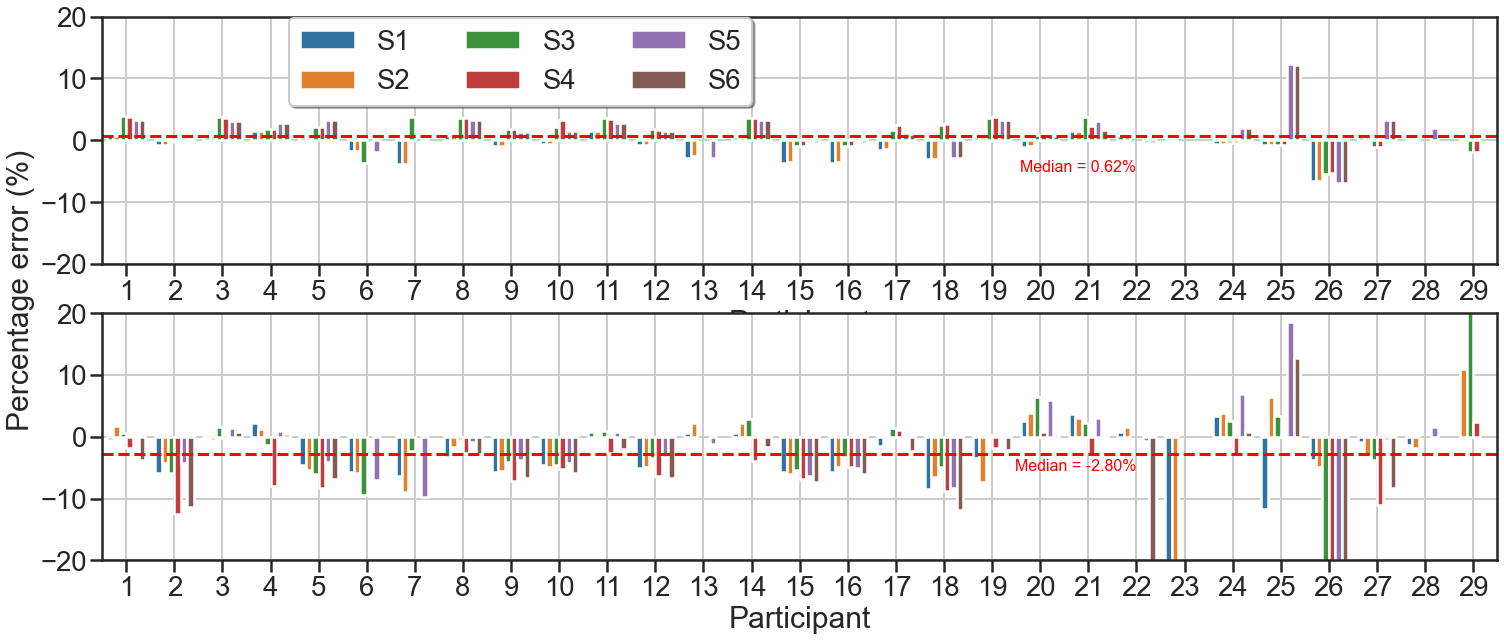

In [69]:
sns.set_context("poster", font_scale=1.25)
ylimits = [-20,20]
#order1 = aaa.sort_values(by=['Percentage Error (%)'])
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))#, sharex = 'all', sharey = 'all')
#ax = sns.boxplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=aaa, linewidth = 2.5, showmeans = True, showfliers=False, ax = axes[0])
ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=irradiation,  linewidth = 2.5, ax = axes[0])
ax.set_ylim(ylimits)
ax.axhline(y=irradiation['Percentage Error (%)'].median(), color='r', ls='--')
print(irradiation['Percentage Error (%)'].median())
#ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
#plt.legend(loc="outer")
ax.annotate('Median = {}%'.format("%.2f" % irradiation['Percentage Error (%)'].median()),xy=(21,-5),ha = 'right',color = 'red',fontsize = 16)
ax.grid(True)
ax.set(ylabel = None)
ax.legend(loc='upper center', bbox_to_anchor=(0.3, 1.05),
          ncol=3, fancybox=True, shadow=True)

ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=energy_yield,  linewidth = 2.5, ax = axes[1])
ax.set_ylim(ylimits)
ax.axhline(y=energy_yield['Percentage Error (%)'].median(), color='r', ls='--')
print(energy_yield['Percentage Error (%)'].median())
#ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
#plt.legend(loc="outer")
ax.annotate('Median = {}%'.format("%.2f" % energy_yield['Percentage Error (%)'].median()),xy=(21,-5.5),ha = 'right',color = 'red',fontsize = 16)
ax.grid(True)
ax.set(ylabel = None)
ax.legend_.remove()
fig.text(0.08,0.5, "Percentage error (%)", ha="center", va="center", rotation=90)
# ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
#           ncol=3, fancybox=True, shadow=True)
plt.show()

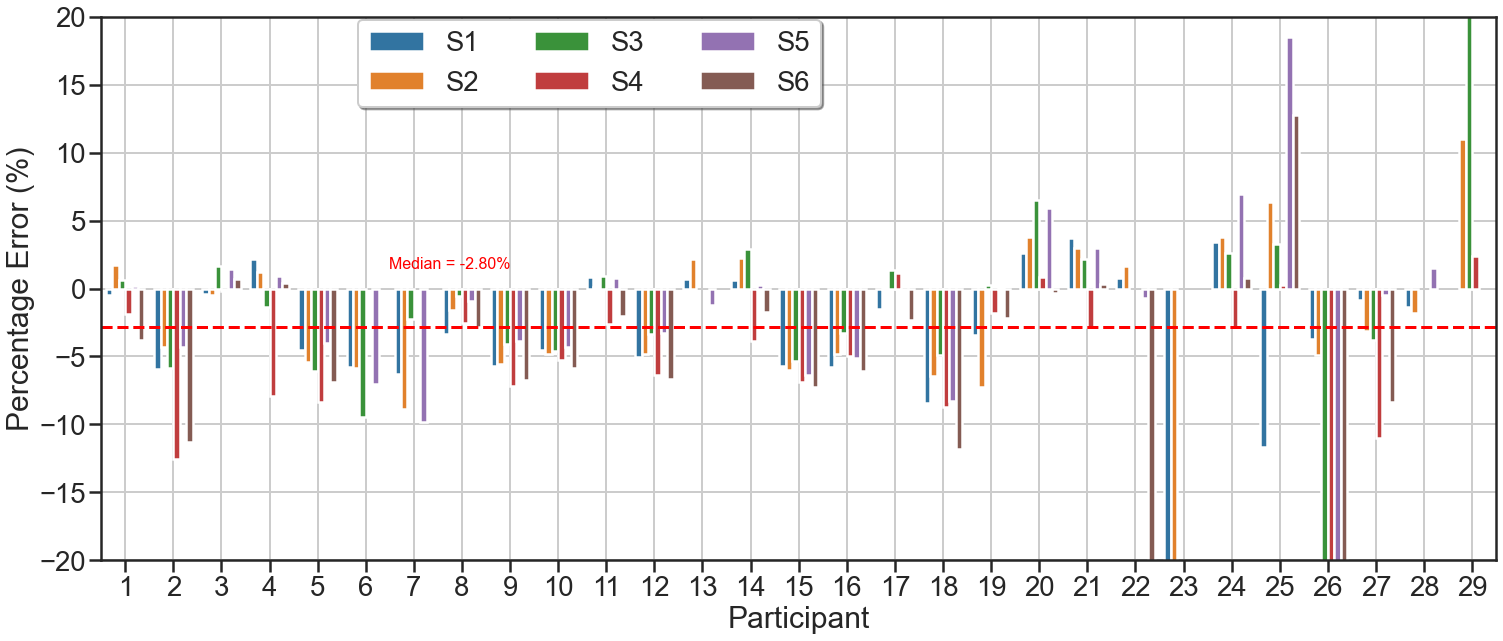

In [70]:
sns.set_context("poster", font_scale=1.25)
ylimits = [-20,20]
#order1 = aaa.sort_values(by=['Percentage Error (%)'])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))#, sharex = 'all', sharey = 'all')
#ax = sns.boxplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=aaa, linewidth = 2.5, showmeans = True, showfliers=False, ax = axes[0])
ax = sns.barplot(x="Participant", y='Percentage Error (%)', hue="Scenario", data=energy_yield,  linewidth = 2.5)#, ax = axes[0])
ax.set_ylim(ylimits)
ax.axhline(y=energy_yield['Percentage Error (%)'].median(), color='r', ls='--')
#ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
#plt.legend(loc="outer")
ax.annotate('Median = {}%'.format("%.2f" % energy_yield['Percentage Error (%)'].median()),xy=(8,1.5),ha = 'right',color = 'red',fontsize = 16)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
plt.show()

# Analysis on hourly data

In [71]:
all_sys

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Participant,Measured POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),DPmp_%,DGpoa_%,DTmod_°C,DPmp_W,DGpoa_W/m2,datetime
1,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,...,1,441.739142,5.177106,1481.974075,14.552570,0.439535,-2.147803,215.665308,1.941599,2020-01-01 09:00:00
2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,...,1,700.841725,15.212283,2690.471151,2.256001,1.292235,-7.804080,-60.697060,-9.056522,2020-01-01 10:00:00
3,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.0895,2.962067,...,1,879.048814,21.670719,3308.159506,1.718062,1.063248,-10.793853,-56.836220,-9.346471,2020-01-01 11:00:00
4,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,...,1,977.742232,30.524462,3591.209115,1.001026,0.891840,-14.320827,-35.948953,-8.719898,2020-01-01 12:00:00
5,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,...,1,922.815757,33.635832,3374.982008,0.691170,1.560019,-15.966027,23.326870,14.396104,2020-01-01 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736171,2019.0,12.0,27.0,14.0,126.901119,568.287851,36.843650,3.248889,72.373889,1.880556,...,27,378.116666,0.000000,5313.032065,2.594901,2.128091,NaN,137.867935,-8.046666,2019-12-27 14:00:00
736172,2019.0,12.0,27.0,15.0,78.767289,436.419702,32.091035,3.031667,72.832778,1.509722,...,27,243.250001,0.000000,2837.167298,21.946795,12.119218,NaN,-622.667298,29.479999,2019-12-27 15:00:00
736203,2019.0,12.0,31.0,13.0,129.999166,313.748497,69.652850,7.138333,75.023333,2.136389,...,27,289.116667,0.000000,4807.539515,1.144858,1.920793,NaN,-55.039515,5.553333,2019-12-31 13:00:00
736204,2019.0,12.0,31.0,14.0,104.271818,201.388605,70.737916,6.780000,75.311666,1.056667,...,27,220.766667,0.000000,3874.418738,8.923112,3.065076,NaN,-345.718738,-6.766667,2019-12-31 14:00:00


In [72]:
meta_text = pd.read_csv(r'C:\Users\mther\Desktop\PVPMC\blind study\Nicholas\meta_answers_recoded Marios.csv')

In [73]:
#meta_text = meta_text[meta_text['Results Submitted?'] == 'True']

In [74]:
meta_text

,Participant,Scenario,Did you use the IEC 61853-1 matrix data?,Did you use the provided PAN file data?,Did you use the provided IAM+NMOT data?,PV performance model,Transposition model,Which irradiance model did you use for the front and rear sides?,Temperature model
0,1,S1,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
1,1,S2,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
2,1,S3,Yes,No,No,PlantPredict,Perez,Marion,PVsyst (Tmod)
3,1,S4,Yes,No,No,PlantPredict,Perez,Marion,PVsyst (Tmod)
4,1,S5,Yes,No,No,PlantPredict,Perez,Marion,PVsyst (Tmod)
...,...,...,...,...,...,...,...,...,...
148,28,S2,Yes,Yes,No,Custom model,Custom model,No Response,Custom model
149,28,S5,No,No,No,Custom model,Custom model,No Response,Custom model
150,29,S2,Yes,No,Yes,PVsyst,Perez,NaN,PVsyst (Tcell)
151,29,S3,No,No,No,PVsyst,Perez,NaN,PVsyst (Tcell)


In [75]:
all_wmeta = all_sys.merge(meta_text, how = 'left', left_on = ['Participant', 'Scenario'], right_on = ['Participant', 'Scenario']) 

In [76]:
all_wmeta

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,DPmp_W,DGpoa_W/m2,datetime,Did you use the IEC 61853-1 matrix data?,Did you use the provided PAN file data?,Did you use the provided IAM+NMOT data?,PV performance model,Transposition model,Which irradiance model did you use for the front and rear sides?,Temperature model
0,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,...,215.665308,1.941599,2020-01-01 09:00:00,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
1,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,...,-60.697060,-9.056522,2020-01-01 10:00:00,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.0895,2.962067,...,-56.836220,-9.346471,2020-01-01 11:00:00,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
3,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,...,-35.948953,-8.719898,2020-01-01 12:00:00,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
4,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,...,23.326870,14.396104,2020-01-01 13:00:00,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427051,2019.0,12.0,27.0,14.0,126.901119,568.287851,36.843650,3.248889,72.373889,1.880556,...,137.867935,-8.046666,2019-12-27 14:00:00,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell)
427052,2019.0,12.0,27.0,15.0,78.767289,436.419702,32.091035,3.031667,72.832778,1.509722,...,-622.667298,29.479999,2019-12-27 15:00:00,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell)
427053,2019.0,12.0,31.0,13.0,129.999166,313.748497,69.652850,7.138333,75.023333,2.136389,...,-55.039515,5.553333,2019-12-31 13:00:00,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell)
427054,2019.0,12.0,31.0,14.0,104.271818,201.388605,70.737916,6.780000,75.311666,1.056667,...,-345.718738,-6.766667,2019-12-31 14:00:00,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell)


In [77]:
# all_wmeta.loc[all_wmeta['Scenario']=='S1', 'res_norm [W/Wp]' ] = all_wmeta['DPmp_W']/3900
# all_wmeta.loc[all_wmeta['Scenario']=='S2', 'res_norm [W/Wp]' ] = all_wmeta['DPmp_W']/3300
# all_wmeta.loc[all_wmeta['Scenario']=='S3', 'res_norm [W/Wp]' ] = all_wmeta['DPmp_W']/26840
# all_wmeta.loc[all_wmeta['Scenario']=='S4', 'res_norm [W/Wp]' ] = all_wmeta['DPmp_W']/25960
# all_wmeta.loc[all_wmeta['Scenario']=='S5', 'res_norm [W/Wp]' ] = all_wmeta['DPmp_W']/26840
# all_wmeta.loc[all_wmeta['Scenario']=='S6', 'res_norm [W/Wp]' ] = all_wmeta['DPmp_W']/25960

all_wmeta.loc[all_wmeta['Scenario']=='S1', 'res_norm [W/kWp]' ] = all_wmeta['DPmp_W']/3.900
all_wmeta.loc[all_wmeta['Scenario']=='S2', 'res_norm [W/kWp]' ] = all_wmeta['DPmp_W']/3.300
all_wmeta.loc[all_wmeta['Scenario']=='S3', 'res_norm [W/kWp]' ] = all_wmeta['DPmp_W']/26.840
all_wmeta.loc[all_wmeta['Scenario']=='S4', 'res_norm [W/kWp]' ] = all_wmeta['DPmp_W']/25.960
all_wmeta.loc[all_wmeta['Scenario']=='S5', 'res_norm [W/kWp]' ] = all_wmeta['DPmp_W']/26.840
all_wmeta.loc[all_wmeta['Scenario']=='S6', 'res_norm [W/kWp]' ] = all_wmeta['DPmp_W']/25.960


In [78]:
all_wmeta.columns

Index(['Year', 'Month', 'Day', 'Hour', 'GHI (W/m2)', 'DNI (W/m2)',
       'DHI (W/m2)', 'Ambient Temp (°C) ', 'Relative Humidity (%)',
       'Wind Speed (m/s)', 'Modeled POA irradiance (W/m2)',
       'Modeled module temperature (°C)', 'Modeled DC power (W)', 'Scenario',
       'Participant', 'Measured POA irradiance (W/m2)',
       'Measured module temperature (°C)', 'Measured DC power (W)', 'DPmp_%',
       'DGpoa_%', 'DTmod_°C', 'DPmp_W', 'DGpoa_W/m2', 'datetime',
       'Did you use the IEC 61853-1 matrix data?',
       'Did you use the provided PAN file data?',
       'Did you use the provided IAM+NMOT data?', 'PV performance model',
       'Transposition model',
       'Which irradiance model did you use for the front and rear sides?',
       'Temperature model', 'res_norm [W/kWp]'],
      dtype='object')

In [79]:
all_wmeta['Tmod_mod-Tamb_meas']=all_wmeta['Modeled module temperature (°C)']-all_wmeta['Ambient Temp (°C) ']
all_wmeta['Tmod_meas-Tamb_meas']=all_wmeta['Measured module temperature (°C)']-all_wmeta['Ambient Temp (°C) ']

In [80]:
all_wmeta

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Did you use the IEC 61853-1 matrix data?,Did you use the provided PAN file data?,Did you use the provided IAM+NMOT data?,PV performance model,Transposition model,Which irradiance model did you use for the front and rear sides?,Temperature model,res_norm [W/kWp],Tmod_mod-Tamb_meas,Tmod_meas-Tamb_meas
0,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),55.298797,6.681686,8.829489
1,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-15.563349,8.116904,15.920983
2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.0895,2.962067,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-14.573390,10.057233,20.851086
3,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-9.217680,14.062935,28.383762
4,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),5.981249,14.433139,30.399166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427051,2019.0,12.0,27.0,14.0,126.901119,568.287851,36.843650,3.248889,72.373889,1.880556,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),5.310783,6.207311,-3.248889
427052,2019.0,12.0,27.0,15.0,78.767289,436.419702,32.091035,3.031667,72.832778,1.509722,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),-23.985643,3.698133,-3.031667
427053,2019.0,12.0,31.0,13.0,129.999166,313.748497,69.652850,7.138333,75.023333,2.136389,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),-2.120166,5.536667,-7.138333
427054,2019.0,12.0,31.0,14.0,104.271818,201.388605,70.737916,6.780000,75.311666,1.056667,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),-13.317363,3.937000,-6.780000


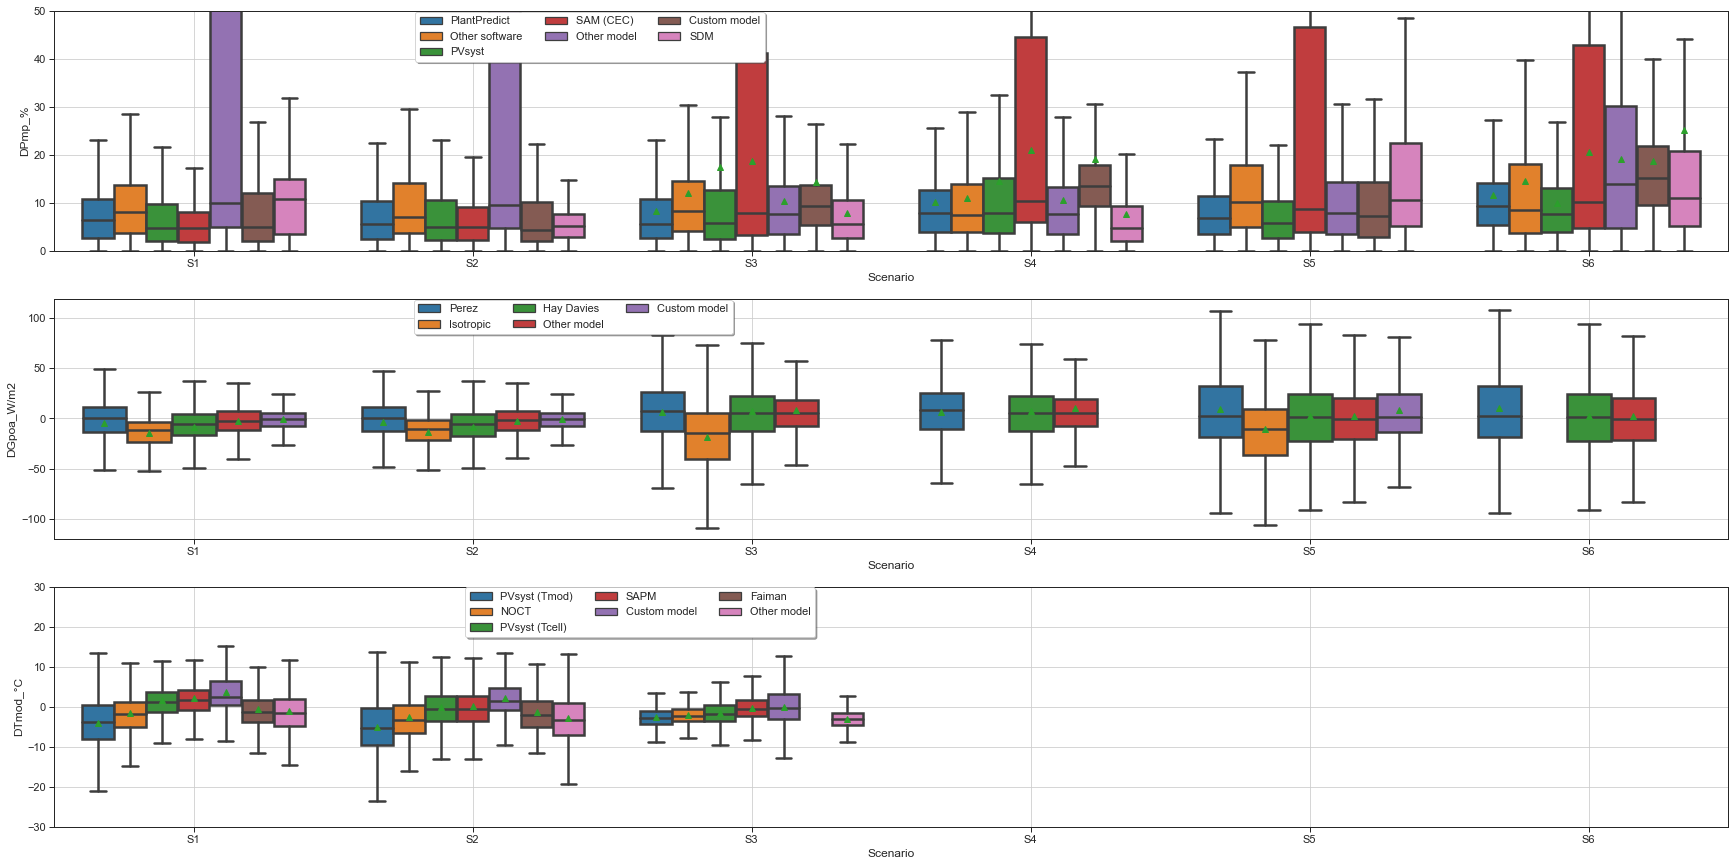

In [81]:
sns.set_context("paper", font_scale=1.25)
ylimits = [0,50]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,15))#, sharex = 'all', sharey = 'all')
ax = sns.boxplot(x="Scenario", y='DPmp_%', hue="PV performance model", data=all_wmeta, linewidth = 2.5, showmeans = True, showfliers=False, ax = axes[0])
ax.set_ylim(ylimits)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.32, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax = sns.boxplot(x="Scenario", y='DGpoa_W/m2', hue="Transposition model", data=all_wmeta, linewidth = 2.5,showmeans = True, showfliers=False,  ax = axes[1])
#ax.set_ylim(ylimits)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.31, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax = sns.boxplot(x="Scenario", y='DTmod_°C', hue="Temperature model", data=all_wmeta, linewidth = 2.5,showmeans = True, showfliers=False,  ax = axes[2])
ax.set_ylim([-30,30])
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
plt.show()

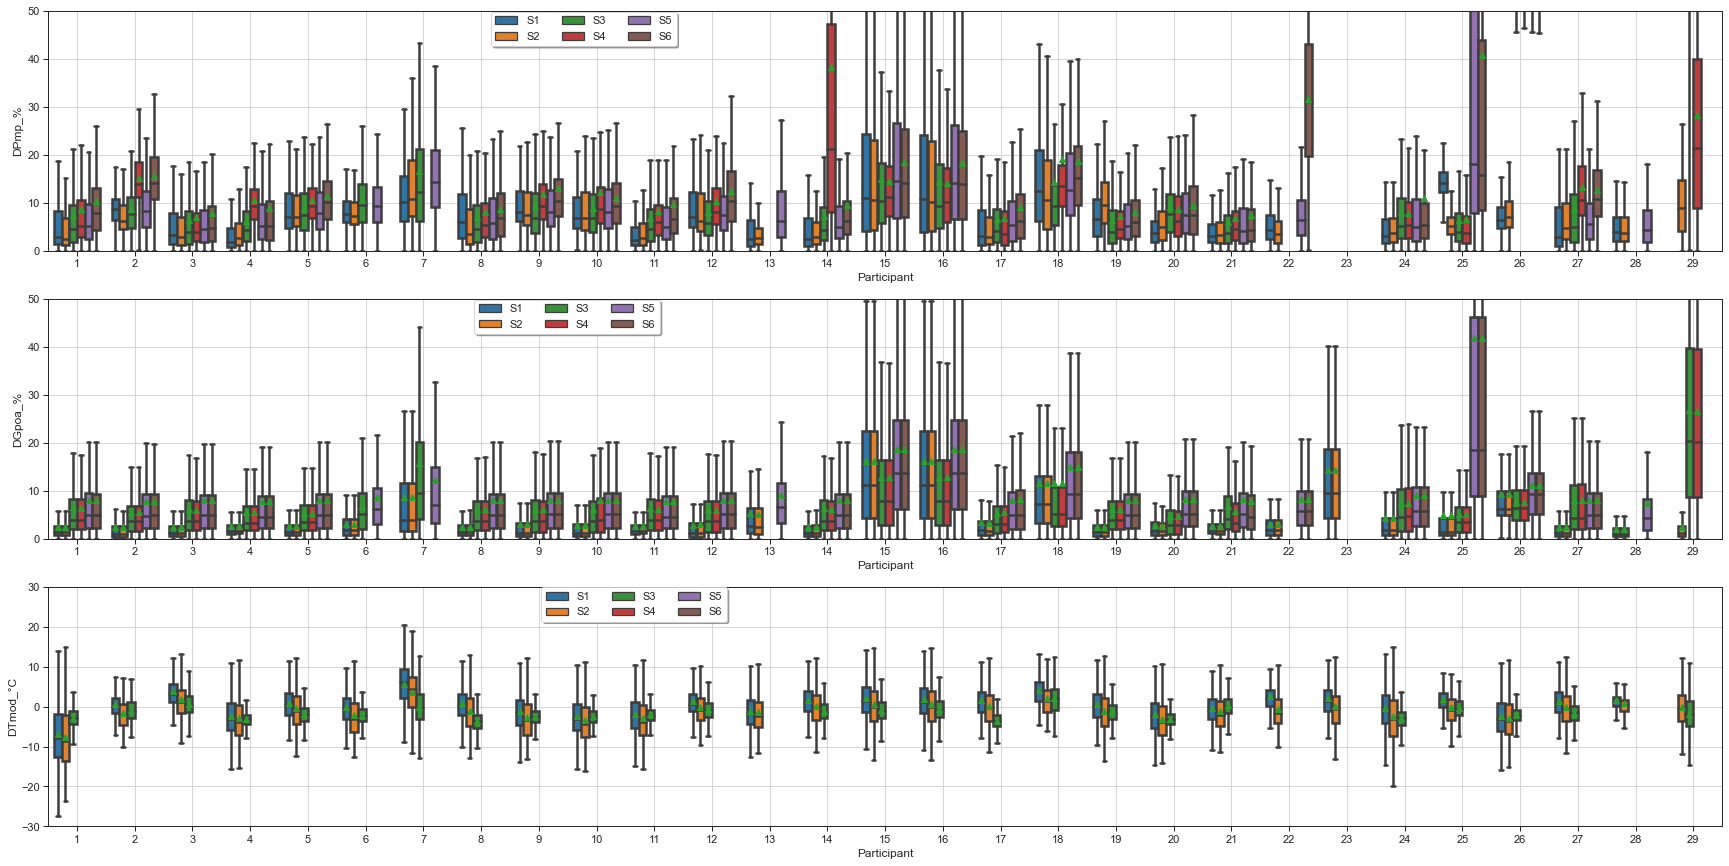

In [82]:
sns.set_context("paper", font_scale=1.25)
ylimits = [0,50]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,15))#, sharex = 'all', sharey = 'all')
ax = sns.boxplot(x="Participant", y='DPmp_%', hue="Scenario", data=all_sys, linewidth = 2.5, showmeans = True, showfliers=False, ax = axes[0])
ax.set_ylim(ylimits)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.32, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax = sns.boxplot(x="Participant", y='DGpoa_%', hue="Scenario", data=all_sys, linewidth = 2.5,showmeans = True, showfliers=False,  ax = axes[1])
ax.set_ylim(ylimits)
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.31, 1.02),
          ncol=3, fancybox=True, shadow=True)
ax = sns.boxplot(x="Participant", y='DTmod_°C', hue="Scenario", data=all_sys, linewidth = 2.5,showmeans = True, showfliers=False,  ax = axes[2])
ax.set_ylim([-30,30])
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
plt.show()

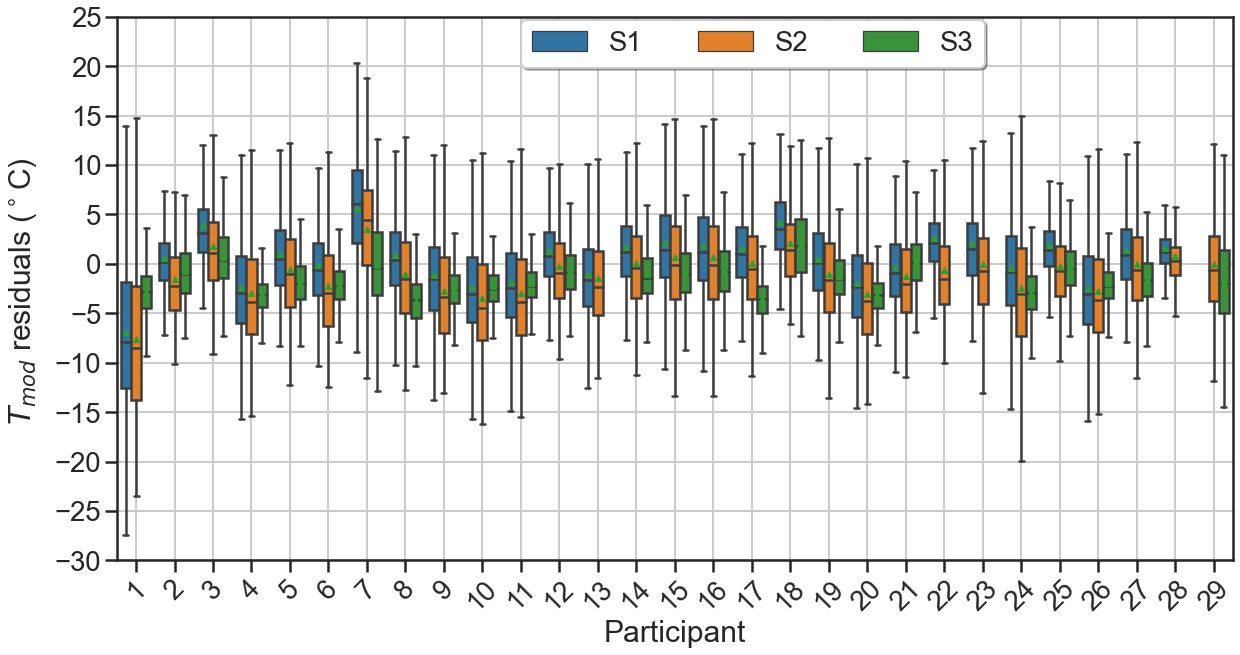

In [83]:
sns.set_context("poster", font_scale=1.25)
ylimits = [0,50]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))#, sharex = 'all', sharey = 'all')

ax = sns.boxplot(x="Participant", y='DTmod_°C', hue="Scenario", data=all_sys.loc[all_sys['Scenario'].isin([ 'S1' , 'S2', 'S3'])], linewidth = 2.5,showmeans = True, showfliers=False)
ax.set_ylim([-30,25])
ax.grid(True)
ax.legend(loc='upper left', bbox_to_anchor=(0.35, 1.02),
          ncol=3, fancybox=True, shadow=True)
#ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 

loc = ticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# ax.annotate('o',xy=(-0.009,0.485),ha = 'center',color = 'red',fontsize = 25)
# ax.annotate('x = -0.009 W/Wp',xy=(-0.0,0.485),ha = 'left',color = 'red',fontsize = 15)
fig.text(0.06,0.5, "$T_{mod}$ residuals ($^\circ$C)", ha="center", va="center", rotation=90)

plt.show()

In [84]:
# sns.set_context("poster", font_scale=1.03)
# #palette = sns.color_palette(['grey'],n_colors = len(all_sys['Participant'].unique()))
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,14))# sharex = 'all', sharey = 'all')
# ax = sns.ecdfplot(data = S1, x = 'res_norm [W/Wp]', hue = 'PV performance model',stat = 'proportion', alpha = 0.2)#, ax = axes[0])
# sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5)#, ax = axes[0,0])
# #ax.legend_.remove()
# ax.set_xlim([-0.1, 0.1])
# ax.set_title('S1')
# ax.grid(True)
# # ax.set(xlabel = None)
# # ax.set(ylabel = None)
# ax.tick_params('x', labelrotation=45) 
# loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
# ax.xaxis.set_major_locator(loc)
# loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
# ax.yaxis.set_major_locator(loc)
# #ax.annotate('o',xy=(-0.029,0.485),ha = 'center',color = 'red',fontsize = 25)
# #ax.annotate('x = -0.29 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)





# #plt.legend(loc = (1.04,0))


# # fig.text(0.08,0.5, "Cumulative Probability", ha="center", va="center", rotation=90)
# # fig.text(0.5,0.05, "Normalized power residuals (W/Wp)", ha="center", va="center", rotation=0)



time:  2.0838050842285156  sec


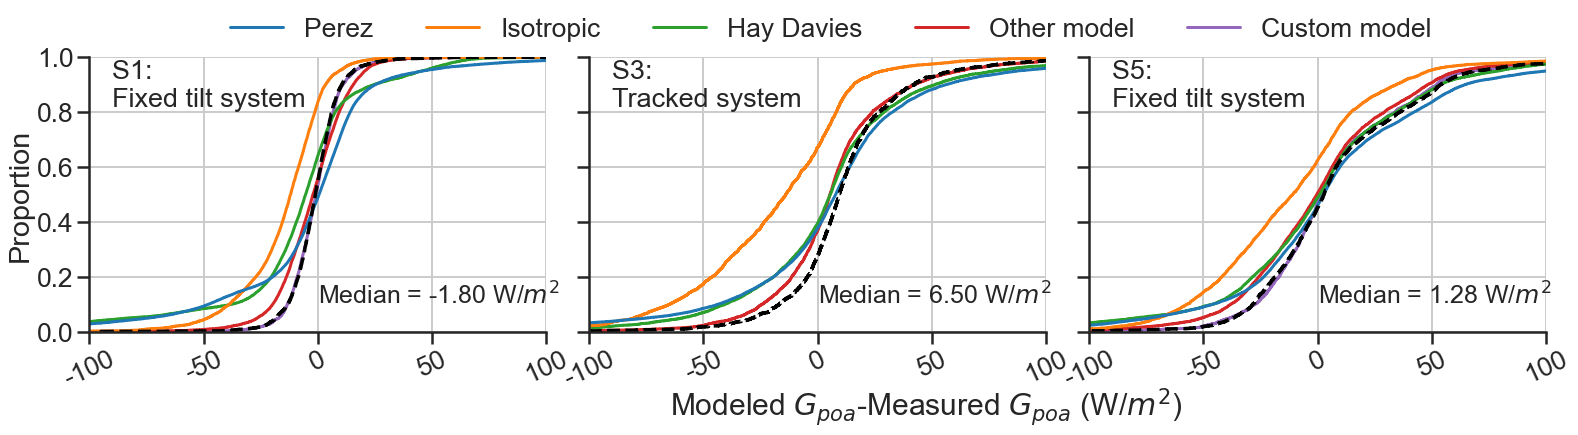

In [85]:
start = time.time()
sns.set_context("poster", font_scale=1.2)

sns.set_style("ticks",{'axes.grid' : True})
g = sns.displot(data=all_wmeta[all_wmeta.Scenario.isin(['S1','S3','S5'])], x = 'DGpoa_W/m2', col="Scenario", hue="Transposition model", kind = 'ecdf', col_wrap=3,  height = 6, aspect = 1.25)

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S1'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
g.axes[0].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S1'])]['DGpoa_W/m2'].median()), fontsize = 25)
g.axes[0].text(-90, 0.82,'S1: \nFixed tilt system', fontsize = 27)

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S3'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
g.axes[1].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S3'])]['DGpoa_W/m2'].median()), fontsize = 25)
g.axes[1].text(-90, 0.82,'S3: \nTracked system', fontsize = 27)

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S5'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
g.axes[2].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S5'])]['DGpoa_W/m2'].median()), fontsize = 25)
g.axes[2].text(-90, 0.82,'S5: \nFixed tilt system', fontsize = 27)

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S4'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[3])
# g.axes[3].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S4'])]['DGpoa_W/m2'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S5'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[4])
# g.axes[4].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S5'])]['DGpoa_W/m2'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S6'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[5])
# g.axes[5].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S6'])]['DGpoa_W/m2'].median()))

g.set(xlim=(-100, 100))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Proportion')
#g.fig.supylabel("Density")
g.fig.supxlabel("Modeled $G_{poa}$-Measured $G_{poa}$ (W/$m^2$)", fontsize = 30)
g.set(xticks=np.arange(-100,150,50))
g.set_xticklabels(np.arange(-100,150,50), rotation=25)

sns.move_legend(g, "lower center", bbox_to_anchor=(.45, .85), ncol=5, title=None, frameon=False,)

g.set_titles(col_template = '')

end = time.time()
print('time: ', (end-start), ' sec')



time:  2.7504217624664307  sec


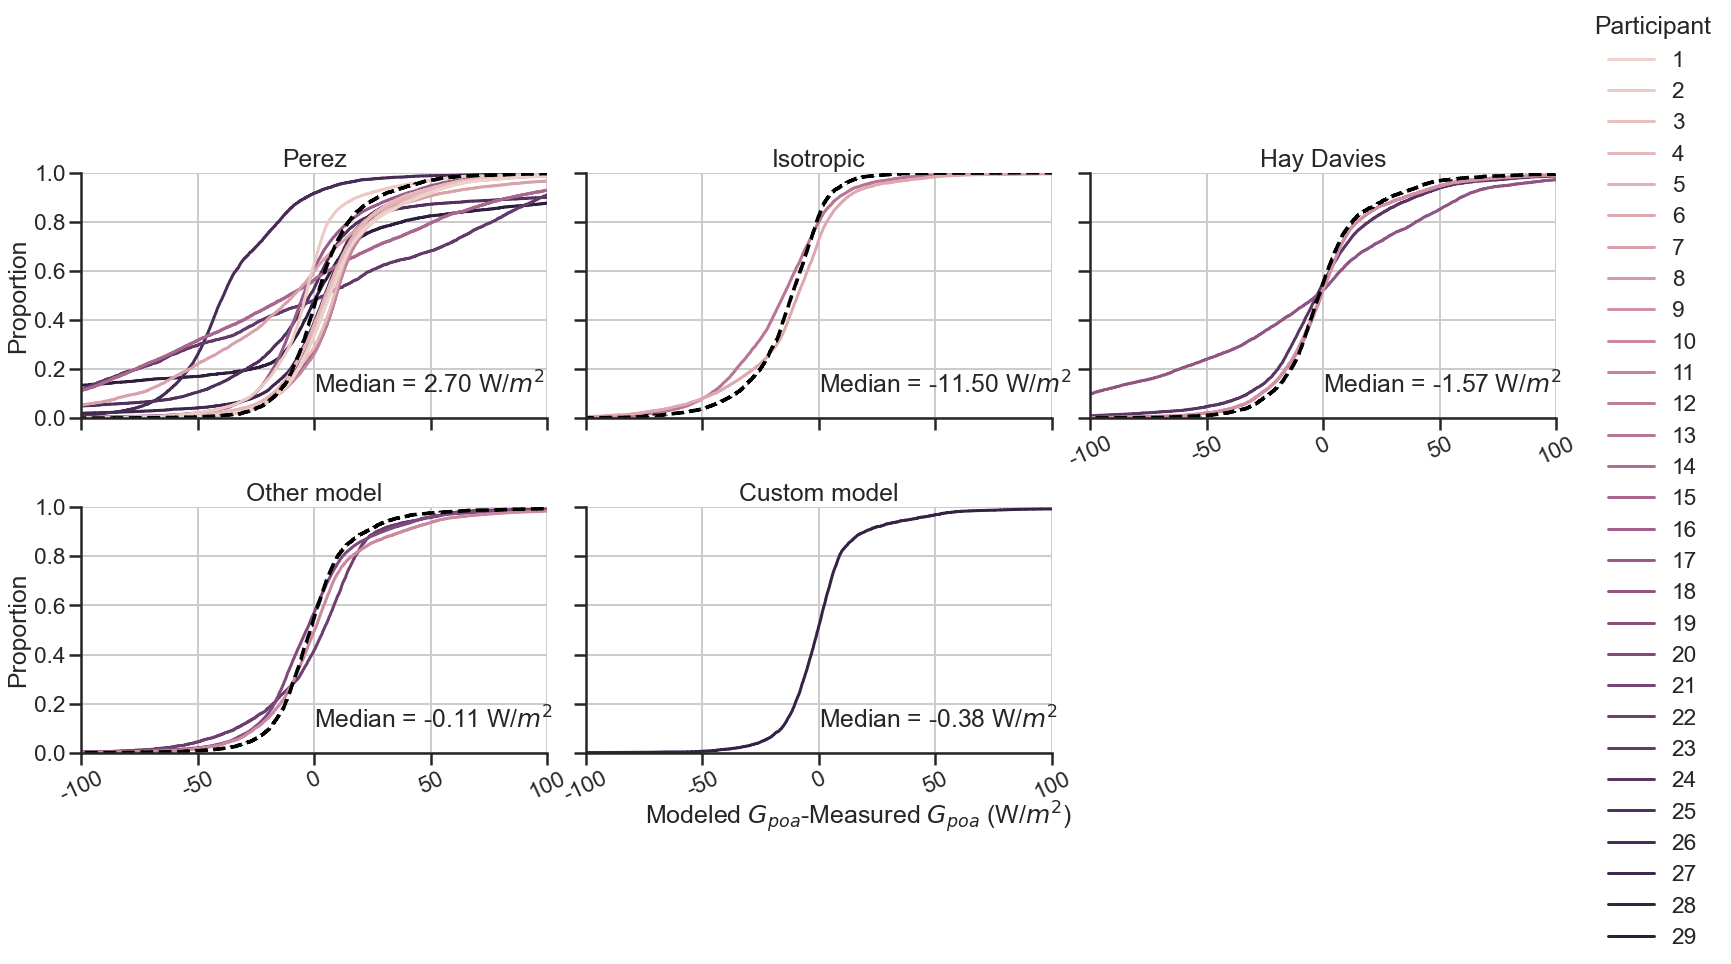

In [86]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})
g = sns.displot(data=all_wmeta, x = 'DGpoa_W/m2', col="Transposition model", hue="Participant", kind = 'ecdf', col_wrap=3,  height = 5, aspect = 1.5)

sns.ecdfplot(data = all_wmeta[all_wmeta['Transposition model'].isin(['Perez'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
g.axes[0].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['Perez'])]['DGpoa_W/m2'].median()))#,xy=(8,1.5),ha = 'right',color = 'red',fontsize = 16)

sns.ecdfplot(data = all_wmeta[all_wmeta['Transposition model'].isin(['Isotropic'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
g.axes[1].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['Isotropic'])]['DGpoa_W/m2'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['Transposition model'].isin(['Hay Davies'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
g.axes[2].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['Hay Davies'])]['DGpoa_W/m2'].median()))


sns.ecdfplot(data = all_wmeta[all_wmeta['Transposition model'].isin(['Other model'])].groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[3])
g.axes[3].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['Other model'])]['DGpoa_W/m2'].median()))
               
# g.axes[3].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['HDKR'])]['DGpoa_W/m2'].median()))

g.axes[4].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['Custom model'])]['DGpoa_W/m2'].median()))
# g.axes[5].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['King'])]['DGpoa_W/m2'].median()))
# g.axes[6].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['custom'])]['DGpoa_W/m2'].median()))
# g.axes[7].text(0, 0.1,'Median = {} W/$m^2$'.format("%.2f" % all_wmeta[all_wmeta['Transposition model'].isin(['No Response'])]['DGpoa_W/m2'].median()))

g.set(xlim=(-100, 100))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Proportion')
#g.fig.supylabel("Density")
g.fig.supxlabel("Modeled $G_{poa}$-Measured $G_{poa}$ (W/$m^2$)", fontsize = 25)
g.set(xticks=np.arange(-100,150,50))
g.set_xticklabels(np.arange(-100,150,50), rotation=25)

g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



In [87]:
all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0.75) & (all_wmeta['Wind Speed (m/s)'] < 1.25)]

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Did you use the IEC 61853-1 matrix data?,Did you use the provided PAN file data?,Did you use the provided IAM+NMOT data?,PV performance model,Transposition model,Which irradiance model did you use for the front and rear sides?,Temperature model,res_norm [W/kWp],Tmod_mod-Tamb_meas,Tmod_meas-Tamb_meas
21,2020.0,1.0,4.0,9.0,195.545210,755.705995,41.043538,-1.961850,58.971833,0.807100,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),61.974775,9.048695,10.159105
22,2020.0,1.0,4.0,10.0,356.084477,896.591241,44.493093,-0.267417,50.315333,1.032267,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-13.776202,12.707567,21.254782
29,2020.0,1.0,5.0,9.0,194.815757,729.576056,48.172837,0.403567,55.106167,0.989767,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),56.209100,8.365733,8.420147
46,2020.0,1.0,7.0,9.0,190.244498,793.069451,23.893812,-1.658767,45.619667,1.104383,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),54.468278,8.224826,9.450020
111,2020.0,1.0,15.0,9.0,197.120342,499.080323,89.382995,2.733183,37.391833,1.067867,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),32.866853,6.914008,6.062289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426994,2019.0,11.0,8.0,15.0,94.706611,62.505111,81.169230,8.905555,79.349167,1.080000,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),-11.068722,3.039445,-8.905555
426995,2019.0,11.0,9.0,12.0,113.320929,3.386081,112.229053,7.411944,88.984166,0.979167,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),-26.447230,2.807056,-7.411944
427018,2019.0,11.0,14.0,15.0,120.938970,374.906533,58.480399,8.458333,76.551667,0.855556,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),3.518291,5.316667,-8.458333
427035,2019.0,12.0,2.0,15.0,81.600606,326.614178,42.623477,5.520000,73.501667,1.090556,...,No,No,No,PVsyst,Perez,The Perez model,PVsyst (Tcell),18.672697,3.540800,-5.520000


time:  2.0158424377441406  sec


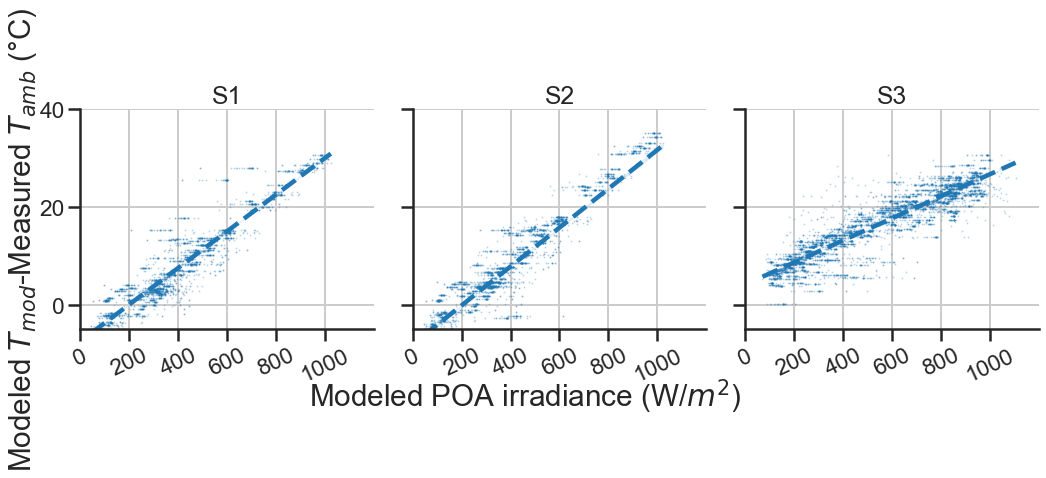

In [88]:
start = time.time()
sns.set_context("poster", font_scale=1.03)
sns.set_style("ticks",{'axes.grid' : True})
g = sns.lmplot(data=all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0.75) & (all_wmeta['Wind Speed (m/s)'] < 1.25) & (all_wmeta['Scenario'].isin(['S1','S2','S3']))], x = 'Modeled POA irradiance (W/m2)', y = 'Tmod_meas-Tamb_meas', col="Scenario",col_wrap=3, robust = False, scatter_kws={"s": 1, 'alpha':0.2}, facet_kws =dict(sharex = True, sharey = True), line_kws = {'linestyle' : "--"})
g.set(xlim=(0, 1200))
g.set(ylim=(-5, 40))
g.set_axis_labels('', '')
g.fig.supxlabel("Modeled POA irradiance (W/$m^2$)")
g.fig.supylabel("Modeled $T_{mod}$-Measured $T_{amb}$ (°C)")
# for lh in g._legend.legendHandles: 
#     lh.set_alpha(1)
#     lh._sizes = [50] 

g.set(xticks=np.arange(0,1200,200))
g.set_xticklabels(np.arange(0,1200,200), rotation=25)
    
g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



time:  1.587110996246338  sec


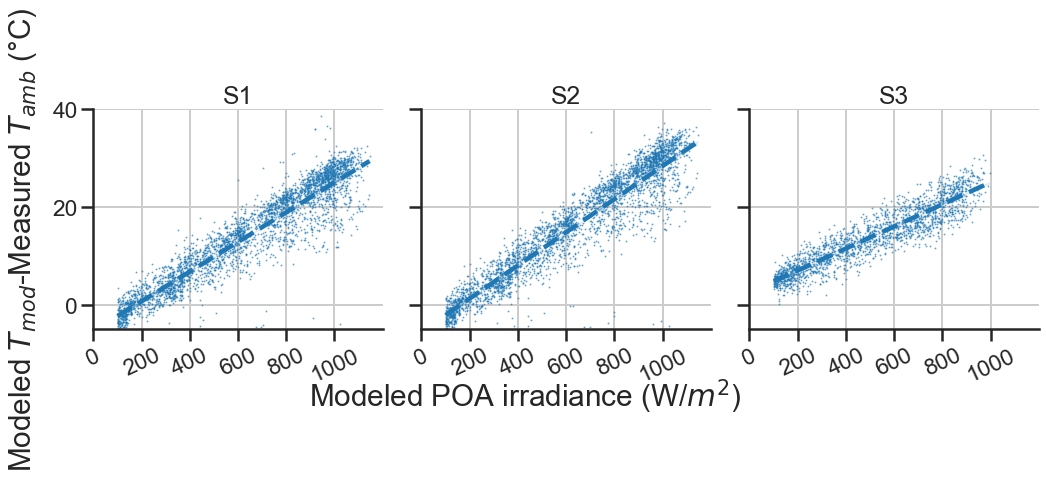

In [89]:
start = time.time()
sns.set_context("poster", font_scale=1.03)
sns.set_style("ticks",{'axes.grid' : True})
g = sns.lmplot(data=all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0) & (all_wmeta['Wind Speed (m/s)'] < 40) & (all_wmeta['Scenario'].isin(['S1','S2','S3'])) & (all_wmeta['Participant'] == 1)], x = 'Measured POA irradiance (W/m2)', y = 'Tmod_meas-Tamb_meas', col="Scenario",col_wrap=3, robust = False, scatter_kws={"s": 1, 'alpha':0.5}, facet_kws =dict(sharex = True, sharey = True), line_kws = {'linestyle' : "--"})
g.set(xlim=(0, 1200))
g.set(ylim=(-5, 40))
g.set_axis_labels('', '')
g.fig.supxlabel("Modeled POA irradiance (W/$m^2$)")
g.fig.supylabel("Modeled $T_{mod}$-Measured $T_{amb}$ (°C)")
# for lh in g._legend.legendHandles: 
#     lh.set_alpha(1)
#     lh._sizes = [50] 

g.set(xticks=np.arange(0,1200,200))
g.set_xticklabels(np.arange(0,1200,200), rotation=25)
    
g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



In [90]:
all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0) & (all_wmeta['Wind Speed (m/s)'] < 2) & (all_wmeta['Scenario'].isin(['S1'])) & (all_wmeta['Participant'] == 1)]

,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),...,Did you use the IEC 61853-1 matrix data?,Did you use the provided PAN file data?,Did you use the provided IAM+NMOT data?,PV performance model,Transposition model,Which irradiance model did you use for the front and rear sides?,Temperature model,res_norm [W/kWp],Tmod_mod-Tamb_meas,Tmod_meas-Tamb_meas
0,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),55.298797,6.681686,8.829489
3,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-9.217680,14.062935,28.383762
4,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),5.981249,14.433139,30.399166
5,2020.0,1.0,1.0,14.0,477.149709,731.146246,136.008643,4.609283,32.452667,1.977850,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-6.757868,11.550644,23.749108
21,2020.0,1.0,4.0,9.0,195.545210,755.705995,41.043538,-1.961850,58.971833,0.807100,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),61.974775,9.048695,10.159105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,2020.0,12.0,26.0,9.0,172.071627,663.986938,30.957464,-0.465700,34.0535,1.063700,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),47.583175,7.445269,6.170745
3494,2020.0,12.0,26.0,10.0,357.214346,938.901651,37.200631,1.665483,28.478167,1.013817,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-17.918740,12.974691,19.414108
3501,2020.0,12.0,27.0,9.0,185.827835,766.698604,31.808968,3.843800,32.196167,1.162967,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),39.508154,7.874687,7.027267
3502,2020.0,12.0,27.0,10.0,347.878593,908.856589,38.231203,7.016917,26.281,1.374583,...,Yes,No,Yes,PlantPredict,Perez,Marion,PVsyst (Tmod),-20.954299,11.465544,18.098722


In [91]:
all_wmeta.columns

Index(['Year', 'Month', 'Day', 'Hour', 'GHI (W/m2)', 'DNI (W/m2)',
       'DHI (W/m2)', 'Ambient Temp (°C) ', 'Relative Humidity (%)',
       'Wind Speed (m/s)', 'Modeled POA irradiance (W/m2)',
       'Modeled module temperature (°C)', 'Modeled DC power (W)', 'Scenario',
       'Participant', 'Measured POA irradiance (W/m2)',
       'Measured module temperature (°C)', 'Measured DC power (W)', 'DPmp_%',
       'DGpoa_%', 'DTmod_°C', 'DPmp_W', 'DGpoa_W/m2', 'datetime',
       'Did you use the IEC 61853-1 matrix data?',
       'Did you use the provided PAN file data?',
       'Did you use the provided IAM+NMOT data?', 'PV performance model',
       'Transposition model',
       'Which irradiance model did you use for the front and rear sides?',
       'Temperature model', 'res_norm [W/kWp]', 'Tmod_mod-Tamb_meas',
       'Tmod_meas-Tamb_meas'],
      dtype='object')

time:  83.31719946861267  sec


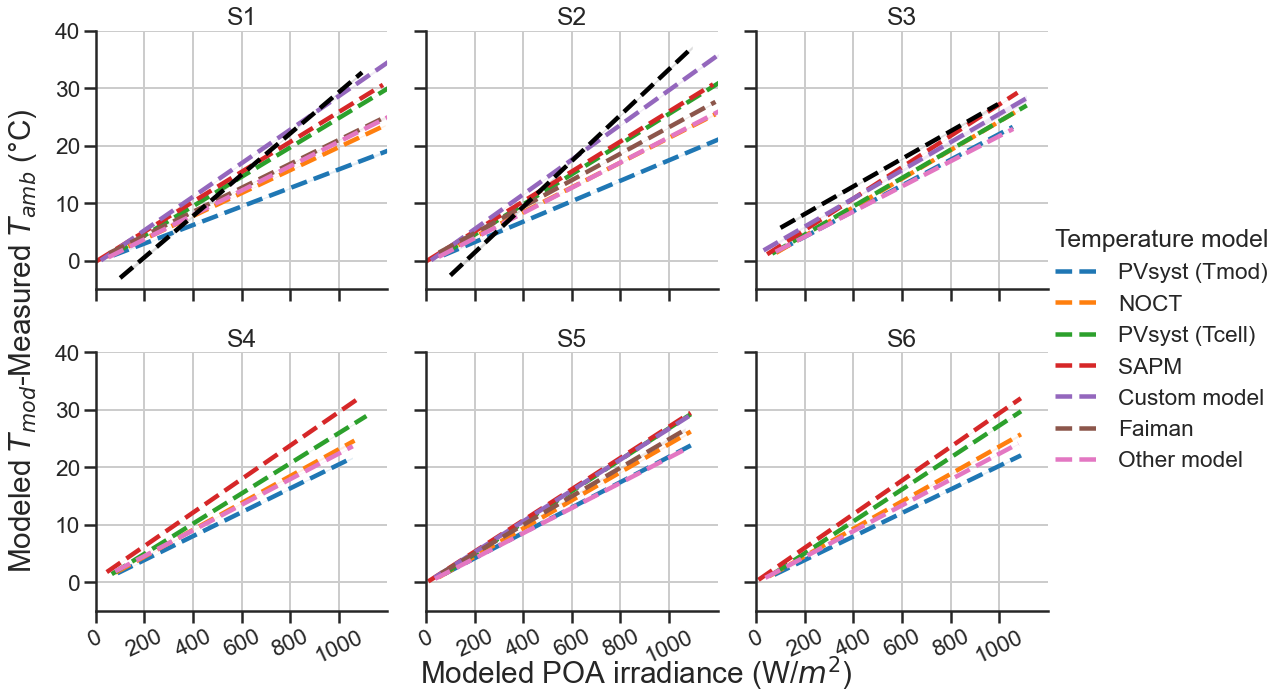

In [92]:
start = time.time()
sns.set_context("poster", font_scale=1.03)
sns.set_style("ticks",{'axes.grid' : True})
g = sns.lmplot(data=all_wmeta, x = 'Modeled POA irradiance (W/m2)', y = 'Tmod_mod-Tamb_meas', col="Scenario", hue="Temperature model", col_wrap=3, robust = False, scatter = False, scatter_kws={"s": 1, 'alpha':0.2}, facet_kws =dict(sharex = True, sharey = True), line_kws = {'linestyle' : "--"})



sns.regplot(data=all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0) & (all_wmeta['Wind Speed (m/s)'] < 2) & (all_wmeta['Scenario'].isin(['S1'])) & (all_wmeta['Participant'] == 1) & (all_wmeta['Measured module temperature (°C)'] > 0)], x = 'Measured POA irradiance (W/m2)', y = 'Tmod_meas-Tamb_meas', scatter = False, robust = True, color = 'black', marker = 'x', scatter_kws={"s": 1, 'alpha':0.2}, line_kws = {'linestyle' : "--"}, ax = g.axes[0])
sns.regplot(data=all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0) & (all_wmeta['Wind Speed (m/s)'] < 2) & (all_wmeta['Scenario'].isin(['S2'])) & (all_wmeta['Participant'] == 1) & (all_wmeta['Measured module temperature (°C)'] > 0)], x = 'Measured POA irradiance (W/m2)', y = 'Tmod_meas-Tamb_meas', scatter = False, robust = True, color = 'black', marker = 'x', scatter_kws={"s": 1, 'alpha':0.2}, line_kws = {'linestyle' : "--"}, ax = g.axes[1])
sns.regplot(data=all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0) & (all_wmeta['Wind Speed (m/s)'] < 2) & (all_wmeta['Scenario'].isin(['S3'])) & (all_wmeta['Participant'] == 1) & (all_wmeta['Measured module temperature (°C)'] > 0)], x = 'Measured POA irradiance (W/m2)', y = 'Tmod_meas-Tamb_meas', scatter = False, robust = True, color = 'black', marker = 'x', scatter_kws={"s": 1, 'alpha':0.2}, line_kws = {'linestyle' : "--"}, ax = g.axes[2])

g.set(xlim=(0, 1200))
g.set(ylim=(-5, 40))
g.set_axis_labels('', '')
g.fig.supxlabel("Modeled POA irradiance (W/$m^2$)")
g.fig.supylabel("Modeled $T_{mod}$-Measured $T_{amb}$ (°C)")
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 

g.set(xticks=np.arange(0,1200,200))
g.set_xticklabels(np.arange(0,1200,200), rotation=25)
    
g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



In [93]:
test = all_wmeta.loc[(all_wmeta['Wind Speed (m/s)'] > 0) & (all_wmeta['Wind Speed (m/s)'] < 400) & (all_wmeta['Scenario'].isin(['S1'])) & (all_wmeta['Participant'] == 1) & (all_wmeta['Measured module temperature (°C)'] > 0)]
test.to_csv('test.csv')

In [94]:
all_wmeta[all_wmeta.Scenario.isin(['S1','S2','S3'])].groupby(['Month','Day','Hour', 'Scenario'])[['DTmod_°C']].median()

DTmod_°C
Month Day  Hour Scenario          
1.0   1.0  9.0  S1        1.576434
                S2        0.829226
           10.0 S1        0.305717
                S2       -1.650519
           11.0 S1       -0.181219
...                            ...
12.0  30.0 16.0 S2       -0.107169
      31.0 12.0 S3       -0.922629
           13.0 S3       -0.193333
           14.0 S3       -0.597000
           15.0 S3       -0.259667

[9094 rows x 1 columns]

time:  2.195751190185547  sec


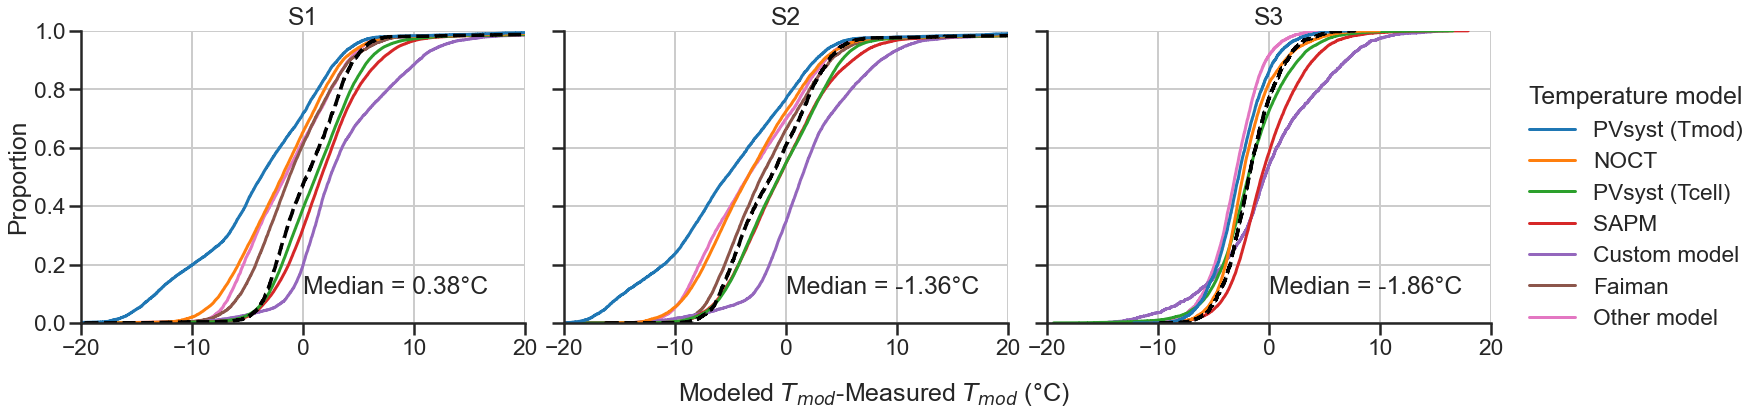

In [95]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})
g = sns.displot(data=all_wmeta[all_wmeta.Scenario.isin(['S1','S2','S3'])], x = 'DTmod_°C', col="Scenario", hue="Temperature model", kind = 'ecdf', col_wrap=3,  height = 6, aspect = 1.2)

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S1'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
g.axes[0].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S1'])]['DTmod_°C'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S2'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
g.axes[1].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S2'])]['DTmod_°C'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S3'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
g.axes[2].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S3'])]['DTmod_°C'].median()))

g.set(xlim=(-20, 20))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Proportion')
#g.fig.supylabel("Density")
g.fig.supxlabel("Modeled $T_{mod}$-Measured $T_{mod}$ (°C)", fontsize = 25)


g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



In [96]:
all_wmeta[all_wmeta['Temperature model'].isin(['PVsyst (Tmod)'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median()

DTmod_°C
Month Day  Hour           
1.0   1.0  9.0   -0.962162
           10.0  -5.350290
           11.0  -8.136089
           12.0 -12.407623
           13.0 -14.531629
...                    ...
12.0  30.0 16.0  -2.059217
      31.0 12.0  -0.949767
           13.0  -0.326946
           14.0  -0.951698
           15.0  -0.232598

[3810 rows x 1 columns]

In [97]:
all_wmeta[all_wmeta['Temperature model'].isin(['PVsyst (Tmod)'])]['DTmod_°C'].median()

-3.672083829568498

time:  2.537557363510132  sec


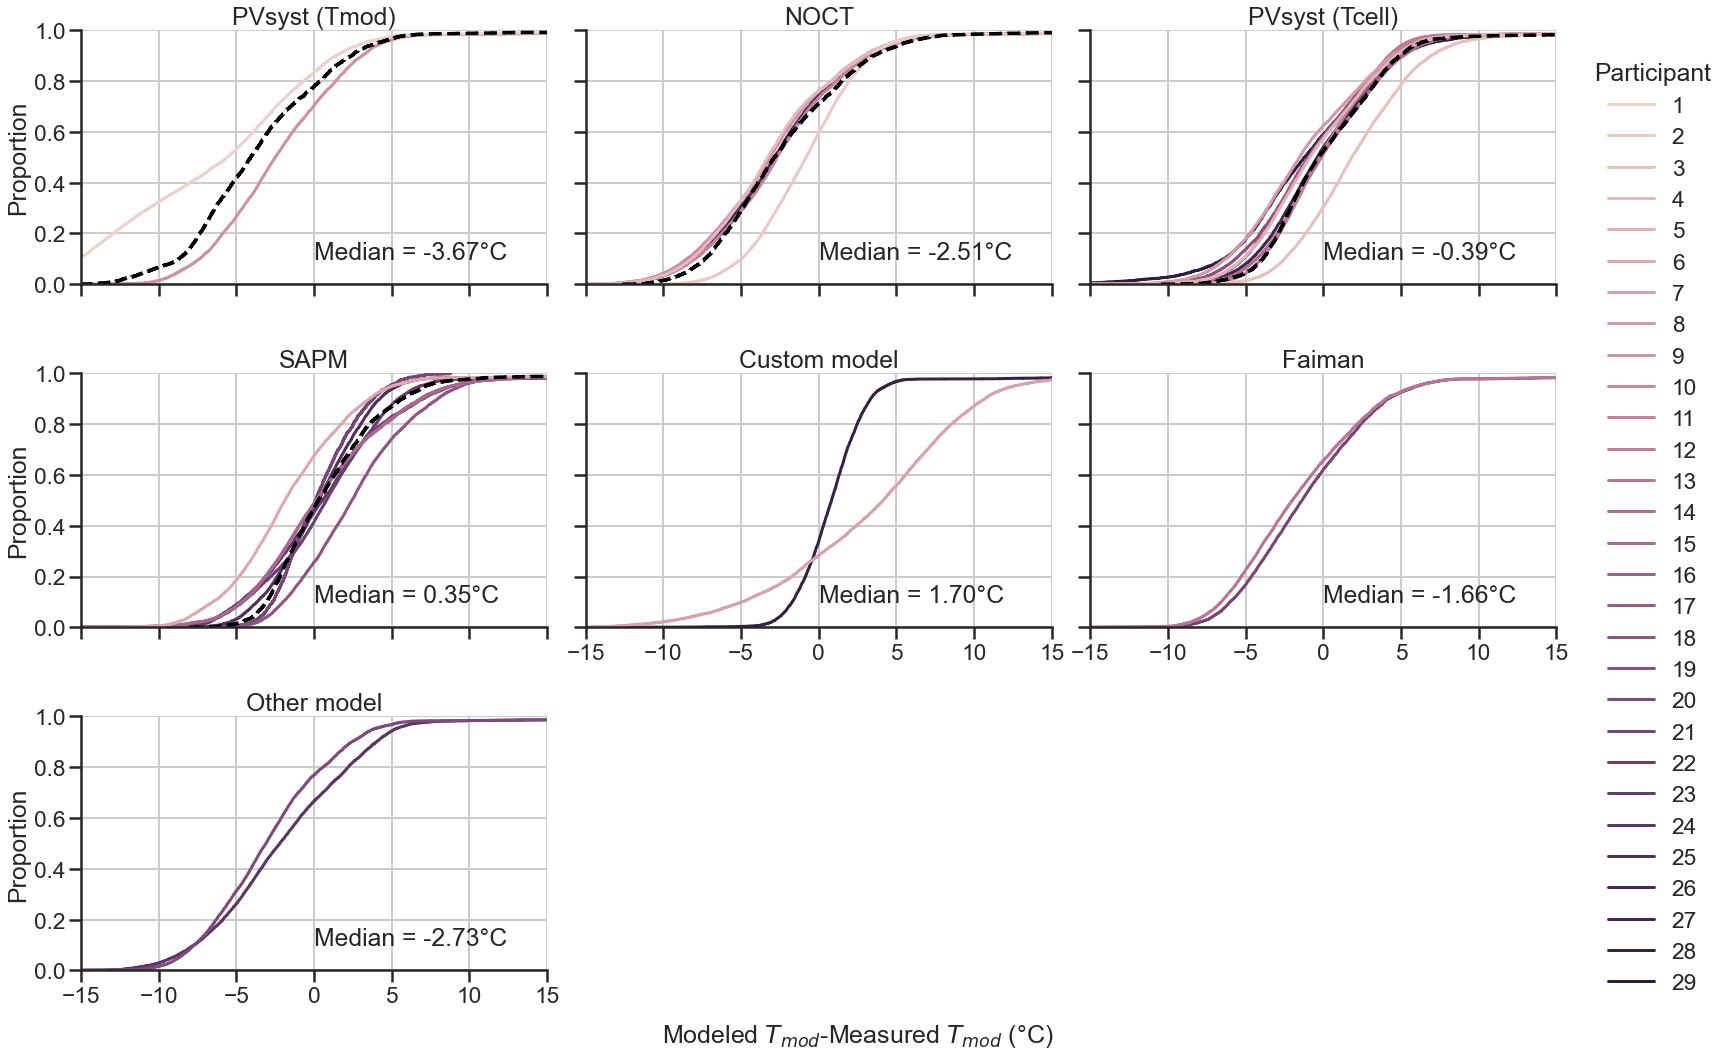

In [98]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})
g = sns.displot(data=all_wmeta, x = 'DTmod_°C', col="Temperature model", hue="Participant", kind = 'ecdf', col_wrap=3,  height = 5, aspect = 1.5)

sns.ecdfplot(data = all_wmeta[all_wmeta['Temperature model'].isin(['PVsyst (Tmod)'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
g.axes[0].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['PVsyst (Tmod)'])]['DTmod_°C'].median()))#,xy=(8,1.5),ha = 'right',color = 'red',fontsize = 16)

sns.ecdfplot(data = all_wmeta[all_wmeta['Temperature model'].isin(['NOCT'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
g.axes[1].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['NOCT'])]['DTmod_°C'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['Temperature model'].isin(['PVsyst (Tcell)'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
g.axes[2].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['PVsyst (Tcell)'])]['DTmod_°C'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['Temperature model'].isin(['SAPM'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[3])
g.axes[3].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['SAPM'])]['DTmod_°C'].median()))

g.axes[4].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['Custom model'])]['DTmod_°C'].median()))
g.axes[5].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['Faiman'])]['DTmod_°C'].median()))
g.axes[6].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['Other model'])]['DTmod_°C'].median()))
#g.axes[7].text(0, 0.1,'Median = {}°C'.format("%.2f" % all_wmeta[all_wmeta['Temperature model'].isin(['custom'])]['DTmod_°C'].median()))

g.set(xlim=(-15, 15))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Proportion')
#g.fig.supylabel("Density")
g.fig.supxlabel("Modeled $T_{mod}$-Measured $T_{mod}$ (°C)", fontsize = 25)


g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



In [99]:
# start = time.time()
# sns.set_context("poster", font_scale=1.03)

# sns.set_style("ticks",{'axes.grid' : True})
# g = sns.displot(data=all_wmeta[all_wmeta.Scenario.isin(['S1','S2','S3'])], x = 'DTmod_°C', col="Scenario", hue="Temperature model", kind = 'kde', col_wrap=3,  height = 5, aspect = 1)

# sns.kdeplot(data = all_wmeta[all_wmeta.Scenario.isin(['S1'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
# sns.kdeplot(data = all_wmeta[all_wmeta.Scenario.isin(['S2'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
# sns.kdeplot(data = all_wmeta[all_wmeta.Scenario.isin(['S3'])].groupby(['Month','Day','Hour'])[['DTmod_°C']].median(), x = 'DTmod_°C',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])

# g.set(xlim=(-20, 20))
# # g.set(ylim=(-5, 40))
# g.set_axis_labels('', 'Density')
# #g.fig.supylabel("Density")
# g.fig.supxlabel("Modeled $T_{mod}$-Measured $T_{mod}$", fontsize = 25)


# g.set_titles(col_template = '{col_name}')
# end = time.time()
# print('time: ', (end-start), ' sec')



time:  2.9003570079803467  sec


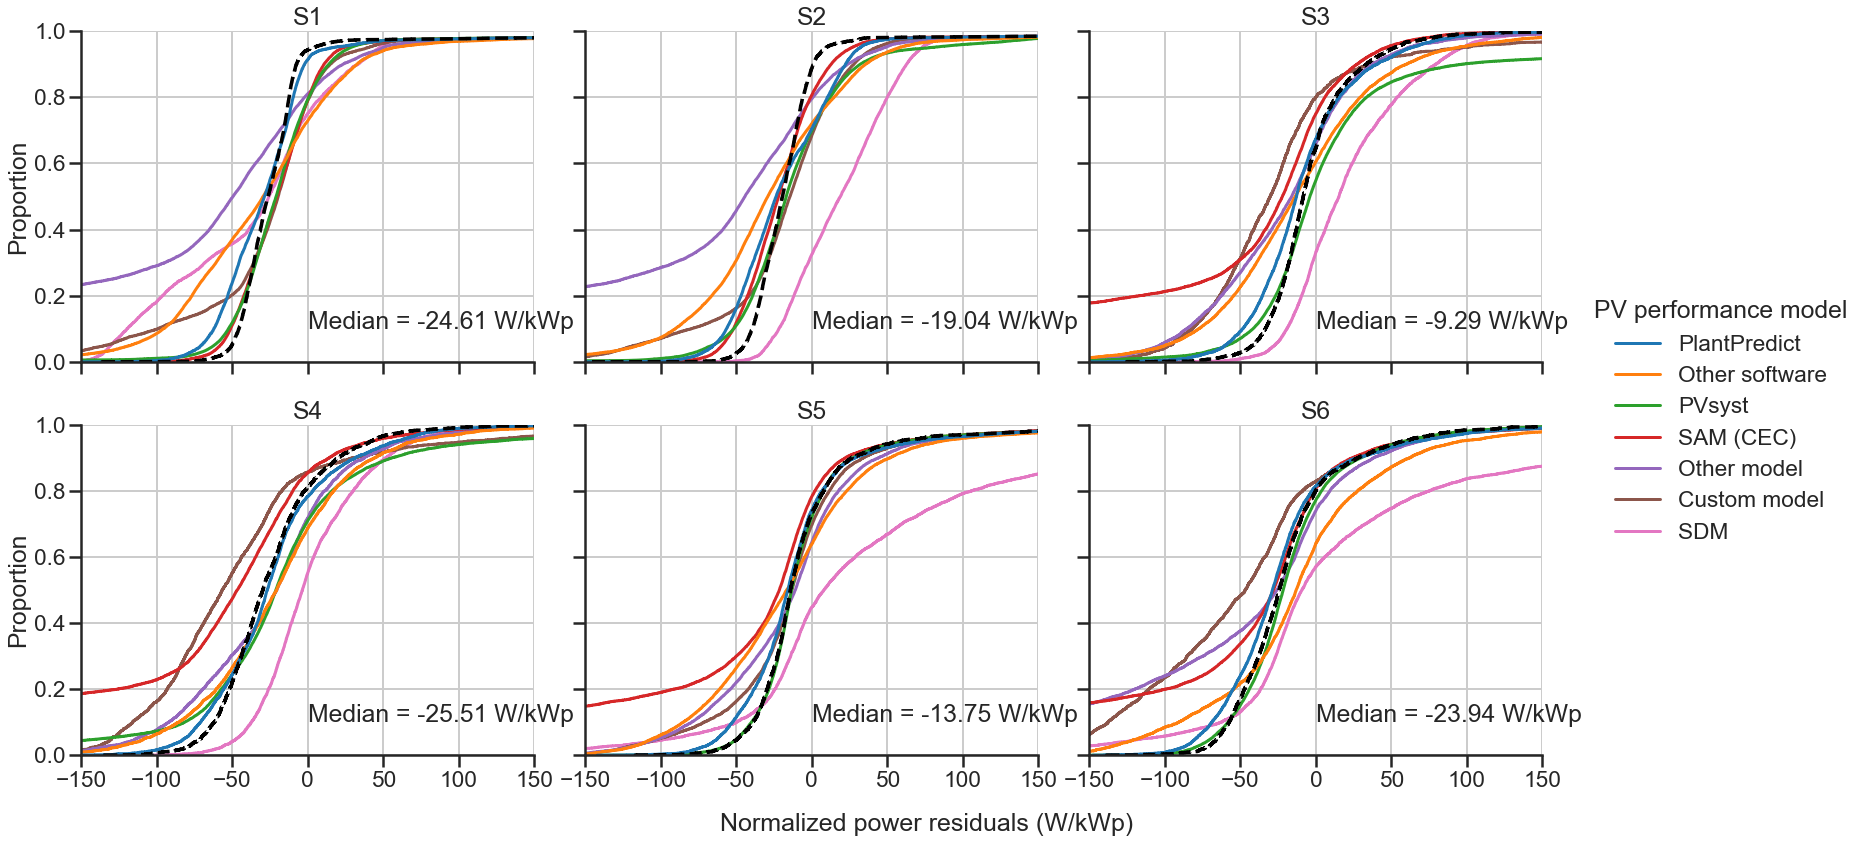

In [100]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})
#g = sns.displot(data=all_wmeta[all_wmeta.Scenario.isin(['S1','S2','S3'])], x = 'DGpoa_W/m2', col="Scenario", hue="Transposition model", kind = 'ecdf', col_wrap=3,  height = 6, aspect = 1.25)
g = sns.displot(data=all_wmeta, x = 'res_norm [W/kWp]', col="Scenario", hue="PV performance model", kind = 'ecdf', col_wrap=3,  height = 6, aspect = 1.25)

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S1'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
g.axes[0].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S1'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S2'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
g.axes[1].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S2'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S3'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
g.axes[2].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S3'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S4'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[3])
g.axes[3].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S4'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S5'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[4])
g.axes[4].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S5'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta.Scenario.isin(['S6'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[5])
g.axes[5].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['Scenario'].isin(['S6'])]['res_norm [W/kWp]'].median()))

g.set(xlim=(-150,150))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Proportion')
#g.fig.supylabel("Density")
g.fig.supxlabel("Normalized power residuals (W/kWp)", fontsize = 25)
# g.set(xticks=np.arange(-2, 2.5,0.5))
# g.set_xticklabels(np.arange(-2, 2.5,0.5), rotation=25)

g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



time:  2.7634356021881104  sec


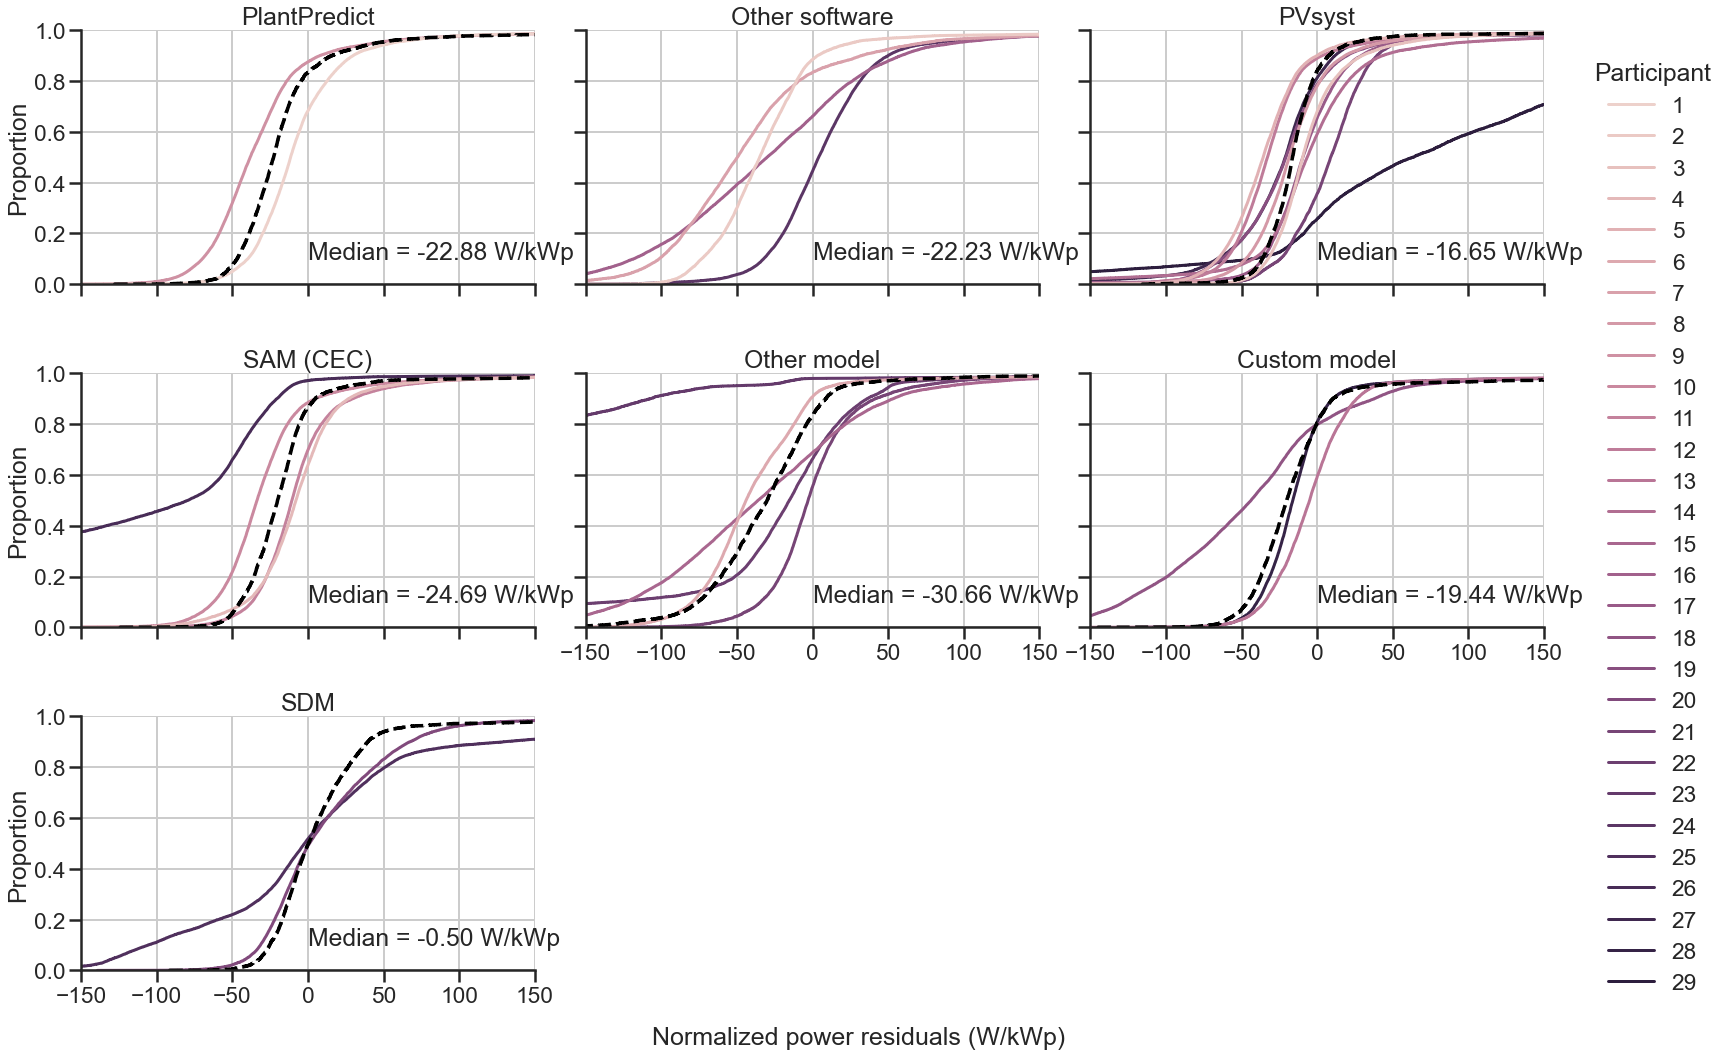

In [101]:
start = time.time()
sns.set_context("poster", font_scale=1.03)

sns.set_style("ticks",{'axes.grid' : True})
g = sns.displot(data=all_wmeta, x = 'res_norm [W/kWp]', col="PV performance model", hue="Participant", kind = 'ecdf', col_wrap=3,  height = 5, aspect = 1.5)

sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['PlantPredict'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[0])
g.axes[0].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['PlantPredict'])]['res_norm [W/kWp]'].median()))#,xy=(8,1.5),ha = 'right',color = 'red',fontsize = 16)

#sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['SAM (PVWatts)'])].groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[1])
g.axes[1].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['Other software'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['PVsyst'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[2])
g.axes[2].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['PVsyst'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['SAM (CEC)'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[3])
g.axes[3].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['SAM (CEC)'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['Other model'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[4])
g.axes[4].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['Other model'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['Custom model'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[5])
g.axes[5].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['Custom model'])]['res_norm [W/kWp]'].median()))

sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['SDM'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[6])
g.axes[6].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['SDM'])]['res_norm [W/kWp]'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['Other'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[7])
# g.axes[7].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['Other'])]['res_norm [W/kWp]'].median()))

# sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['SDM'])].groupby(['Month','Day','Hour'])[['res_norm [W/kWp]']].median(), x = 'res_norm [W/kWp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[8])
# g.axes[8].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['SDM'])]['res_norm [W/kWp]'].median()))

# #sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['SAPM'])].groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[9])
# g.axes[9].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['SAPM'])]['res_norm [W/kWp]'].median()))

# #sns.ecdfplot(data = all_wmeta[all_wmeta['PV performance model'].isin(['CEC Model'])].groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, linestyle = '--', color = 'black', ax = g.axes[10])
# g.axes[10].text(0, 0.1,'Median = {} W/kWp'.format("%.2f" % all_wmeta[all_wmeta['PV performance model'].isin(['CEC Model'])]['res_norm [W/kWp]'].median()))


g.set(xlim=(-150,150))
# g.set(ylim=(-5, 40))
g.set_axis_labels('', 'Proportion')
#g.fig.supylabel("Density")
g.fig.supxlabel("Normalized power residuals (W/kWp)", fontsize = 25)


g.set_titles(col_template = '{col_name}')
end = time.time()
print('time: ', (end-start), ' sec')



In [ ]:
S1.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median()

In [ ]:
sns.set_context("poster", font_scale=1.03)
#palette = sns.color_palette(['grey'],n_colors = len(all_sys['Participant'].unique()))
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,18))# sharex = 'all', sharey = 'all')
ax = sns.displot(data= S1, x = 'res_norm [W/Wp]', hue = 'Participant', kind = "kde", col = 'PV performance model', height=15,aspect=.7) #, alpha = 0.2)#, ax = axes[0])
#ax = sns.displot(data = S1.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',kind = "kde",  linewidth = 3.5, height=10,aspect=2, ax = axes[0])#, ax = axes[0,0])
#ax.legend_.remove()
axes = ax.ax
# #ax.set(xlim=(-25, 25))
# #ax.set(grid = True)
# # ax.set_title('S1')
# axes.grid(True)
#axes.set_xlim([-0.15, 0.15])
# ax.set(xlabel = None)
# ax.set(ylabel = None)
# ax.tick_params('x', labelrotation=45) 
# loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
# ax.xaxis.set_major_locator(loc)
# loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
# ax.yaxis.set_major_locator(loc)
#ax.annotate('o',xy=(-0.029,0.485),ha = 'center',color = 'red',fontsize = 25)
#ax.annotate('x = -0.29 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)





#plt.legend(loc = (1.04,0))


# fig.text(0.08,0.5, "Cumulative Probability", ha="center", va="center", rotation=90)
# fig.text(0.5,0.05, "Normalized power residuals (W/Wp)", ha="center", va="center", rotation=0)



In [ ]:
sns.set_context("poster", font_scale=1.03)
#palette = sns.color_palette(['grey'],n_colors = len(all_sys['Participant'].unique()))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,18))# sharex = 'all', sharey = 'all')
ax = sns.ecdfplot(data = S1, x = 'DGpoa_W/m2', hue = 'Transposition model',stat = 'proportion', alpha = 0.2)#, ax = axes[0])
sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['DGpoa_W/m2']].median(), x = 'DGpoa_W/m2',  linewidth = 3.5)#, ax = axes[0,0])
#ax.legend_.remove()
#ax.set_xlim([-0.1, 0.2])
ax.set_title('S1')
ax.grid(True)
# ax.set(xlabel = None)
# ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
#ax.annotate('o',xy=(-0.029,0.485),ha = 'center',color = 'red',fontsize = 25)
#ax.annotate('x = -0.29 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)





#plt.legend(loc = (1.04,0))


# fig.text(0.08,0.5, "Cumulative Probability", ha="center", va="center", rotation=90)
# fig.text(0.5,0.05, "Normalized power residuals (W/Wp)", ha="center", va="center", rotation=0)



In [ ]:
palette = sns.color_palette(['grey'], len(all_sys['Participant'].unique()))

In [ ]:
sns.set_context("poster", font_scale=1.03)
#palette = sns.color_palette(['grey'],n_colors = len(all_sys['Participant'].unique()))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,18))# sharex = 'all', sharey = 'all')
ax = sns.ecdfplot(data = S1, x = 'res_norm [W/Wp]', hue = 'Participant',stat = 'proportion', alpha = 0.2, ax = axes[0,0])
sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, ax = axes[0,0])
ax.legend_.remove()
ax.set_xlim([-0.1, 0.2])
ax.set_title('S1')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.029,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.29 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)

ax = sns.ecdfplot(data = S2, x = 'res_norm [W/Wp]', hue = 'Participant',stat = 'proportion',palette = palette,alpha = 0.2, ax = axes[0,1])
sns.ecdfplot(data = S2.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, ax = axes[0,1])
ax.legend_.remove()
ax.set_xlim([-0.1, 0.2])
ax.set_title('S2')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45)
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.022,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.22 W/Wp',xy=(-0.01,0.485),ha = 'left',color = 'red',fontsize = 15)

palette3 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S3']['Participant'].unique()))
ax = sns.ecdfplot(data = S3, x = 'res_norm [W/Wp]', hue = 'Participant', stat = 'proportion',palette = palette3,alpha = 0.2,ax = axes[0,2])
sns.ecdfplot(data = S3.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, ax = axes[0,2])
ax.legend_.remove()
ax.set_xlim([-0.10,0.200])
ax.set_title('S3')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.009,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.009 W/Wp',xy=(-0.0,0.485),ha = 'left',color = 'red',fontsize = 15)


palette4 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S4']['Participant'].unique()))
ax = sns.ecdfplot(data = S4, x = 'res_norm [W/Wp]', hue = 'Participant',stat = 'proportion', palette = palette4,alpha = 0.2,ax = axes[1,0])
sns.ecdfplot(data = S4.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, ax = axes[1,0])
ax.legend_.remove()
ax.set_xlim([-0.10,0.200])
ax.set_title('S4')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.028,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.028 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)

palette5 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S5']['Participant'].unique()))
ax = sns.ecdfplot(data =S5, x = 'res_norm [W/Wp]', hue = 'Participant',stat = 'proportion',palette = palette5, alpha = 0.2,ax = axes[1,1])
sns.ecdfplot(data = S5.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, ax = axes[1,1])
ax.legend_.remove()
ax.set_xlim([-0.10,0.200])
ax.set_title('S5')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.0155,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.155 W/Wp',xy=(-0.005,0.485),ha = 'left',color = 'red',fontsize = 15)

palette6 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S6']['Participant'].unique()))
ax = sns.ecdfplot(data = S6, x = 'res_norm [W/Wp]', hue = 'Participant', stat = 'proportion',palette = palette6,alpha = 0.2,ax = axes[1,2])
sns.ecdfplot(data = S6.groupby(['Month','Day','Hour'])[['res_norm [W/Wp]']].median(), x = 'res_norm [W/Wp]',  linewidth = 3.5, ax = axes[1,2])
ax.legend_.remove()
ax.set_xlim([-0.10,0.200])
ax.set_title('S6')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.0245,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.0245 W/Wp',xy=(-0.01,0.485),ha = 'left',color = 'red',fontsize = 15)

fig.text(0.08,0.5, "Cumulative Probability", ha="center", va="center", rotation=90)
fig.text(0.5,0.05, "Normalized power residuals (W/Wp)", ha="center", va="center", rotation=0)
# ax = sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['DPmp_W']].median()], x = 'DPmp_W', hue = 'Participant', linewidth = 1.5, ax = axes[0,0])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S6')
# ax.grid(True)



In [ ]:
sns.set_context("poster", font_scale=1.03)
#palette = sns.color_palette(['grey'], len(all_sys['Participant'].unique()))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,18))# sharex = 'all', sharey = 'all')
ax = sns.ecdfplot(data = S1, x = '|res_norm [W/Wp]|', hue = 'Participant',stat = 'proportion',  alpha = 0.2, ax = axes[0,0])
sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['|res_norm [W/Wp]|']].median(), x = '|res_norm [W/Wp]|',  linewidth = 3.5, ax = axes[0,0])
ax.legend_.remove()
ax.set_xlim([0, 0.2])
ax.set_title('S1')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# ax.annotate('o',xy=(-0.029,0.485),ha = 'center',color = 'red',fontsize = 25)
# ax.annotate('x = -0.29 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)

ax = sns.ecdfplot(data = S2, x = '|res_norm [W/Wp]|', hue = 'Participant',stat = 'proportion',palette = palette,alpha = 0.2, ax = axes[0,1])
sns.ecdfplot(data = S2.groupby(['Month','Day','Hour'])[['|res_norm [W/Wp]|']].median(), x = '|res_norm [W/Wp]|',  linewidth = 3.5, ax = axes[0,1])
ax.legend_.remove()
ax.set_xlim([0, 0.2])
ax.set_title('S2')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45)
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.annotate('o',xy=(-0.022,0.485),ha = 'center',color = 'red',fontsize = 25)
ax.annotate('x = -0.22 W/Wp',xy=(-0.01,0.485),ha = 'left',color = 'red',fontsize = 15)

palette3 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S3']['Participant'].unique()))
ax = sns.ecdfplot(data = S3, x = '|res_norm [W/Wp]|', hue = 'Participant', stat = 'proportion',palette = palette3,alpha = 0.2,ax = axes[0,2])
sns.ecdfplot(data = S3.groupby(['Month','Day','Hour'])[['|res_norm [W/Wp]|']].median(), x = '|res_norm [W/Wp]|',  linewidth = 3.5, ax = axes[0,2])
ax.legend_.remove()
ax.set_xlim([-0,0.200])
ax.set_title('S3')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# ax.annotate('o',xy=(-0.009,0.485),ha = 'center',color = 'red',fontsize = 25)
# ax.annotate('x = -0.009 W/Wp',xy=(-0.0,0.485),ha = 'left',color = 'red',fontsize = 15)


palette4 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S4']['Participant'].unique()))
ax = sns.ecdfplot(data = S4, x = '|res_norm [W/Wp]|', hue = 'Participant',stat = 'proportion', palette = palette4,alpha = 0.2,ax = axes[1,0])
sns.ecdfplot(data = S4.groupby(['Month','Day','Hour'])[['|res_norm [W/Wp]|']].median(), x = '|res_norm [W/Wp]|',  linewidth = 3.5, ax = axes[1,0])
ax.legend_.remove()
ax.set_xlim([-0,0.200])
ax.set_title('S4')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# ax.annotate('o',xy=(-0.028,0.485),ha = 'center',color = 'red',fontsize = 25)
# ax.annotate('x = -0.028 W/Wp',xy=(-0.02,0.485),ha = 'left',color = 'red',fontsize = 15)

palette5 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S5']['Participant'].unique()))
ax = sns.ecdfplot(data =S5, x = '|res_norm [W/Wp]|', hue = 'Participant',stat = 'proportion',palette = palette5, alpha = 0.2,ax = axes[1,1])
sns.ecdfplot(data = S5.groupby(['Month','Day','Hour'])[['|res_norm [W/Wp]|']].median(), x = '|res_norm [W/Wp]|',  linewidth = 3.5, ax = axes[1,1])
ax.legend_.remove()
ax.set_xlim([-0,0.200])
ax.set_title('S5')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# ax.annotate('o',xy=(-0.0155,0.485),ha = 'center',color = 'red',fontsize = 25)
# ax.annotate('x = -0.155 W/Wp',xy=(-0.005,0.485),ha = 'left',color = 'red',fontsize = 15)

palette6 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S6']['Participant'].unique()))
ax = sns.ecdfplot(data = S6, x = '|res_norm [W/Wp]|', hue = 'Participant', stat = 'proportion',palette = palette6,alpha = 0.2,ax = axes[1,2])
sns.ecdfplot(data = S6.groupby(['Month','Day','Hour'])[['|res_norm [W/Wp]|']].median(), x = '|res_norm [W/Wp]|',  linewidth = 3.5, ax = axes[1,2])
ax.legend_.remove()
ax.set_xlim([-0,0.200])
ax.set_title('S6')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)
ax.tick_params('x', labelrotation=45) 
loc = ticker.MultipleLocator(base=0.05) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
# ax.annotate('o',xy=(-0.0245,0.485),ha = 'center',color = 'red',fontsize = 25)
# ax.annotate('x = -0.0245 W/Wp',xy=(-0.01,0.485),ha = 'left',color = 'red',fontsize = 15)

fig.text(0.08,0.5, "Empirical cumulative distribution", ha="center", va="center", rotation=90)
fig.text(0.5,0.05, "Absolute normalized power residuals (W/Wp)", ha="center", va="center", rotation=0)
# ax = sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['DPmp_W']].median()], x = 'DPmp_W', hue = 'Participant', linewidth = 1.5, ax = axes[0,0])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S6')
# ax.grid(True)



In [ ]:
palette = sns.color_palette(['grey'], len(all_sys['Participant'].unique()))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))# sharex = 'all', sharey = 'all')
ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S1'], x = 'DPmp_W', hue = 'Participant',stat = 'proportion', palette = palette, alpha = 0.2, ax = axes[0,0])
sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['DPmp_W']].median(), x = 'DPmp_W',  linewidth = 3.5, ax = axes[0,0])
ax.legend_.remove()
ax.set_xlim([-400, 400])
ax.set_title('S1')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)

ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S2'], x = 'DPmp_W', hue = 'Participant',stat = 'proportion',palette = palette,alpha = 0.2, ax = axes[0,1])
sns.ecdfplot(data = S2.groupby(['Month','Day','Hour'])[['DPmp_W']].median(), x = 'DPmp_W',  linewidth = 3.5, ax = axes[0,1])
ax.legend_.remove()
ax.set_xlim([-400, 400])
ax.set_title('S2')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)

palette3 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S3']['Participant'].unique()))
ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S3'], x = 'DPmp_W', hue = 'Participant', stat = 'proportion',palette = palette3,alpha = 0.2,ax = axes[0,2])
sns.ecdfplot(data = S3.groupby(['Month','Day','Hour'])[['DPmp_W']].median(), x = 'DPmp_W',  linewidth = 3.5, ax = axes[0,2])
ax.legend_.remove()
ax.set_xlim([-3000, 3000])
ax.set_title('S3')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)


palette4 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S4']['Participant'].unique()))
ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S4'], x = 'DPmp_W', hue = 'Participant',stat = 'proportion', palette = palette4,alpha = 0.2,ax = axes[1,0])
sns.ecdfplot(data = S4.groupby(['Month','Day','Hour'])[['DPmp_W']].median(), x = 'DPmp_W',  linewidth = 3.5, ax = axes[1,0])
ax.legend_.remove()
ax.set_xlim([-3000, 3000])
ax.set_title('S4')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)

palette5 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S5']['Participant'].unique()))
ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S5'], x = 'DPmp_W', hue = 'Participant',stat = 'proportion',palette = palette5, alpha = 0.2,ax = axes[1,1])
sns.ecdfplot(data = S5.groupby(['Month','Day','Hour'])[['DPmp_W']].median(), x = 'DPmp_W',  linewidth = 3.5, ax = axes[1,1])
ax.legend_.remove()
ax.set_xlim([-3000, 3000])
ax.set_title('S5')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)

palette6 = sns.color_palette(['grey'], len(all_sys.loc[all_sys['Scenario'] == 'S6']['Participant'].unique()))
ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S6'], x = 'DPmp_W', hue = 'Participant', stat = 'proportion',palette = palette6,alpha = 0.2,ax = axes[1,2])
sns.ecdfplot(data = S6.groupby(['Month','Day','Hour'])[['DPmp_W']].median(), x = 'DPmp_W',  linewidth = 3.5, ax = axes[1,2])
ax.legend_.remove()
ax.set_xlim([-3000, 3000])
ax.set_title('S6')
ax.grid(True)
ax.set(xlabel = None)
ax.set(ylabel = None)

fig.text(0.08,0.5, "Cumulative Probability", ha="center", va="center", rotation=90)
fig.text(0.5,0.08, "Power residuals (W)", ha="center", va="center", rotation=0)
# ax = sns.ecdfplot(data = S1.groupby(['Month','Day','Hour'])[['DPmp_W']].median()], x = 'DPmp_W', hue = 'Participant', linewidth = 1.5, ax = axes[0,0])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S6')
# ax.grid(True)



In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))# sharex = 'all', sharey = 'all')
ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S1'], x = 'DGpoa_W/m2', hue = 'Participant', ax = axes[0,0])
ax.legend_.remove()
ax.set_xlim([-200, 200])
ax.set_title('S1')
ax.grid(True)

ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S2'], x = 'DGpoa_W/m2', hue = 'Participant', ax = axes[0,1])
ax.legend_.remove()
ax.set_xlim([-200, 200])
ax.set_title('S2')
ax.grid(True)

ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S3'], x = 'DGpoa_W/m2', hue = 'Participant', ax = axes[0,2])
ax.legend_.remove()
ax.set_xlim([-200, 200])
ax.set_title('S3')
ax.grid(True)

ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S4'], x = 'DGpoa_W/m2', hue = 'Participant', ax = axes[1,0])
ax.legend_.remove()
ax.set_xlim([-200, 200])
ax.set_title('S4')
ax.grid(True)

ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S5'], x = 'DGpoa_W/m2', hue = 'Participant', ax = axes[1,1])
ax.legend_.remove()
ax.set_xlim([-200, 200])
ax.set_title('S5')
ax.grid(True)

ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S6'], x = 'DGpoa_W/m2', hue = 'Participant', ax = axes[1,2])
ax.legend_.remove()
ax.set_xlim([-200, 200])
ax.set_title('S6')
ax.grid(True)


In [ ]:
all_sys.columns

In [ ]:
all_sys

In [ ]:
test = all_sys.loc[all_sys['Scenario'] == 'S1']
test

In [ ]:
test.loc[test['Participant'] == 13]

In [ ]:
#ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))# sharex = 'all', sharey = 'all')
sns.set_context("paper", font_scale=1.25)
ax = sns.jointplot(data = test, x = 'Hour' , y = 'DPmp_W', kind = 'hex') #test.loc[test['Participant'] == 1],
# ax.legend_.remove()
#ax.set_ylim([-75, 75])
# ax.set_title('S1')
# ax.grid(True)

# ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S2'], x = 'DPmp_W', hue = 'Participant', ax = axes[0,1])
# ax.legend_.remove()
# ax.set_xlim([-1000, 1000])
# ax.set_title('S2')
# ax.grid(True)

# ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S3'], x = 'DPmp_W', hue = 'Participant', ax = axes[0,2])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S3')
# ax.grid(True)

# ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S4'], x = 'DPmp_W', hue = 'Participant', ax = axes[1,0])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S4')
# ax.grid(True)

# ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S5'], x = 'DPmp_W', hue = 'Participant', ax = axes[1,1])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S5')
# ax.grid(True)

# ax = sns.ecdfplot(data = all_sys.loc[all_sys['Scenario'] == 'S6'], x = 'DPmp_W', hue = 'Participant', ax = axes[1,2])
# ax.legend_.remove()
# ax.set_xlim([-6000, 6000])
# ax.set_title('S6')
# ax.grid(True)


In [ ]:
# S1, S2, S5 monofacial fixed
# S3 monofacial tracked
# S4 bifacial tracked
# S6 bifacial fixed

In [ ]:
all_sys.columns

In [ ]:
mono_fixed = all_sys.loc[all_sys['Scenario'].isin([ 'S1' , 'S2', 'S5'])]
mono_tracked = all_sys.loc[all_sys['Scenario'].isin([ 'S3'])]
bi_tracked = all_sys.loc[all_sys['Scenario'].isin([ 'S4'])]
bi_fixed = all_sys.loc[all_sys['Scenario'].isin([ 'S6'])]

In [ ]:
ylimits = [0,250]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,5))#, sharex = 'all', sharey = 'all')
ax = sns.boxplot(x="Participant", y='DPmp_%', hue="Scenario", data=meta_mono, linewidth = 2.5, showmeans = True, showfliers=False)#, ax = axes[0])
ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Participant", y='DGpoa_%', hue="Scenario", data=meta_mono, linewidth = 2.5, ax = axes[1])
# ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Participant", y='DTmod_%', hue="Scenario", data=meta_mono, linewidth = 2.5, ax = axes[2])
# ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
plt.show()

In [ ]:
#remove data with irradiance != 1000
meta_ABQ = meta_mono[meta_mono['Scenario'].isin(['S1', 'S2'])]
meta_ABQ

In [ ]:
ylimits = [0,50]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,5))#, sharex = 'all', sharey = 'all')
ax = sns.boxplot(x="Participant", y='DPmp_%', hue="Scenario", data=meta_ABQ, linewidth = 2.5, showmeans = True, showfliers=False)#, ax = axes[0])
ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Participant", y='DGpoa_%', hue="Scenario", data=meta_mono, linewidth = 2.5, ax = axes[1])
# ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Participant", y='DTmod_%', hue="Scenario", data=meta_mono, linewidth = 2.5, ax = axes[2])
# ax.set_ylim(ylimits)
# ax = sns.boxplot(x="Scenario", y="MAE (%/year)", hue="Participant", data=meta_mono, linewidth = 2.5, ax = axes[1,1])
# ax.set_ylim(ylimits)
#ax = sns.swarmplot(x="Method", y="|DRd1|", data = meta, color=".25")
plt.show()

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.5 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Corr. Coeff")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')        
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("St Dev")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("St Dev")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=8, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l
    def add_contours(self,levels=5,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, s, r, l, fname):
    fig=plt.figure()
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = plt.matplotlib.cm.Set1(np.linspace(0, 1, len(l)))
    srlc = zip(s, r, l, cs)
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker='s')
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='medium'), loc=[0.8, 0.1])
    plt.title('DC Performance Models')
    plt.savefig(fname, dpi=300)
    plt.clf()
    plt.close(fig)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = [0.85, 0.86, 0.87, 0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.5 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.grid()
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Corr. Coeff")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')        
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("St Dev")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("St Dev")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=8, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l
    def add_contours(self,levels=5,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, s, r, l, fname):
    fig=plt.figure()
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = plt.matplotlib.cm.Set1(np.linspace(0, 1, len(l)))
    srlc = zip(s, r, l, cs)
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker='s')
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='medium'), loc=[0.8, 0.7])
    plt.title('POA Models')
    plt.savefig(fname, dpi=300)
    plt.clf()
    plt.close(fig)